Aplicando series temporales a analisis media de cohorte diaria

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

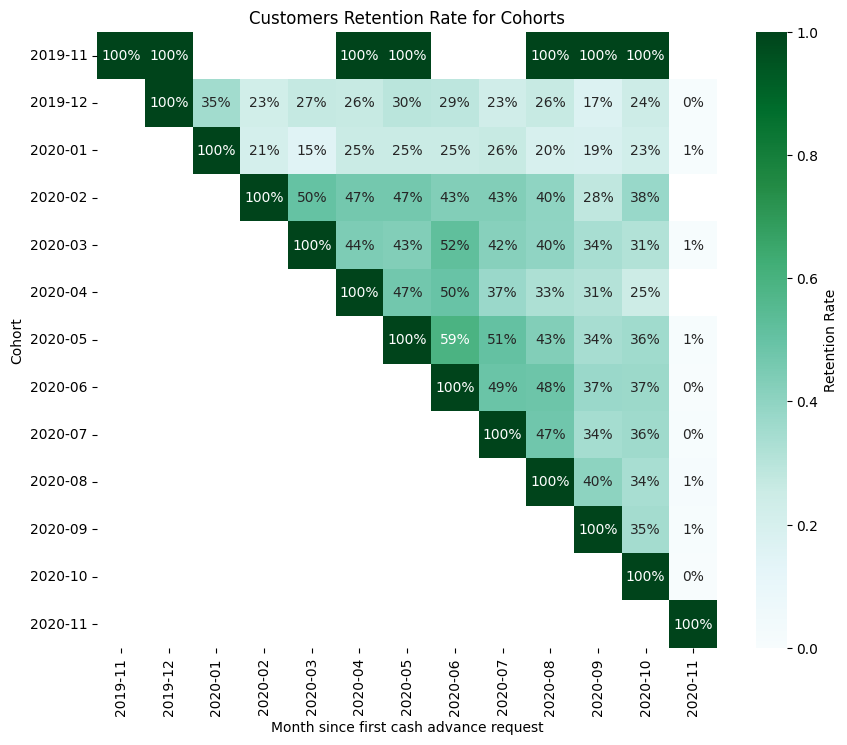

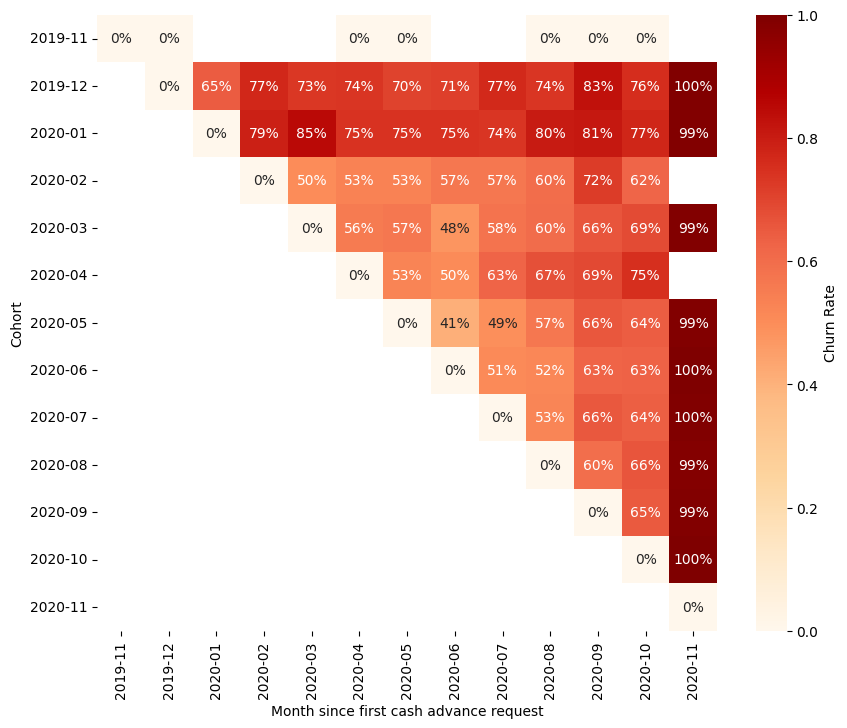

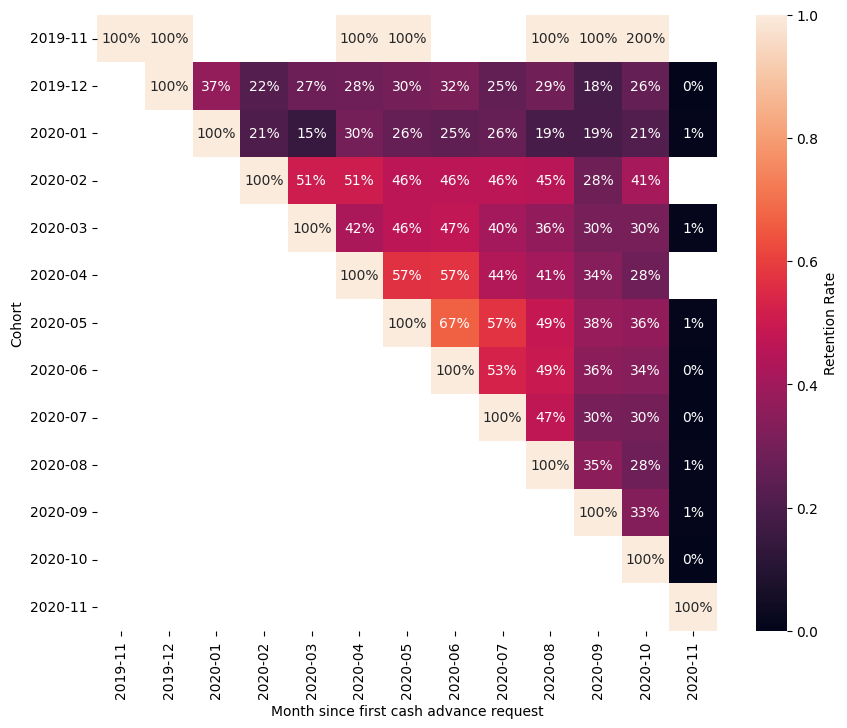

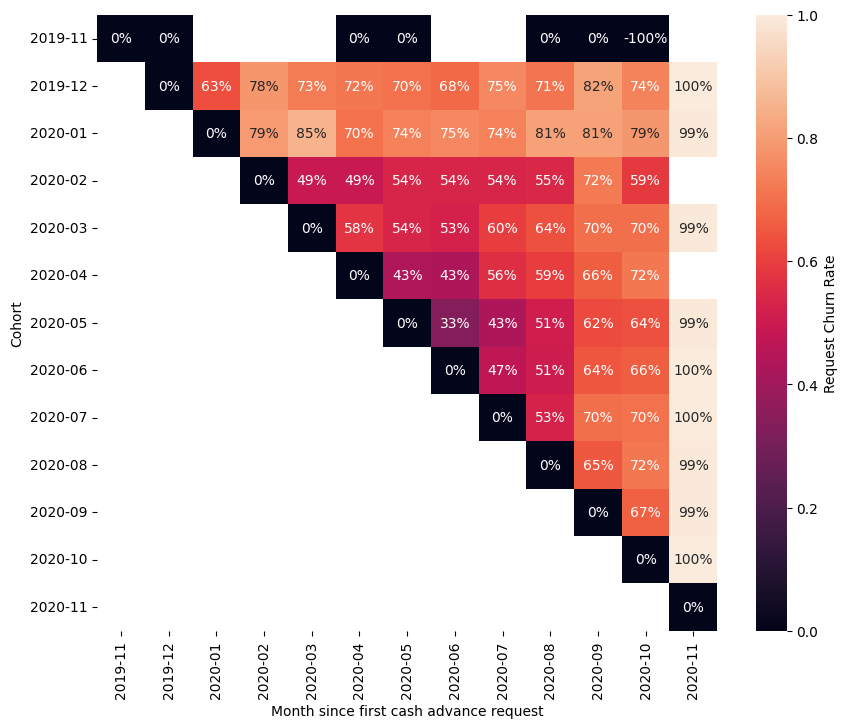

Month  Retention_Rate  Month_Num
0  2019-11-01             NaN          0
1  2019-12-01             NaN          1
2  2020-01-01             NaN          2
3  2020-02-01        1.000000          3
4  2020-03-01        0.505155          4
5  2020-04-01        0.505155          5
6  2020-05-01        0.463918          6
7  2020-06-01        0.463918          7
8  2020-07-01        0.463918          8
9  2020-08-01        0.453608          9
10 2020-09-01        0.278351         10
11 2020-10-01        0.412371         11
12 2020-11-01             NaN         12

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
fees= pd.read_csv('./data/extract - fees - data analyst - .csv')
cash_request= pd.read_csv('./data/extract - cash request - data analyst.csv')

cash_request.info()

cr= cash_request.copy()
cr=cr[['amount','created_at', 'user_id', 'deleted_account_id', 'transfer_type']]
cr.info()

cr.fillna({'user_id':cr['deleted_account_id']}, inplace=True)
cr.drop(columns=['deleted_account_id'], inplace=True)
cr.info()

cr['created_at']=pd.to_datetime(cr['created_at'])
cr.head()

cr['created_at']=cr['created_at'].dt.tz_localize(None)
cr.head()

cr['Month']=cr['created_at'].dt.to_period('M')
cr

cr['Cohort']=cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
cr.head()


# calculate the number of the unique customers in each cohort
cohort_initial_sizes= cr.groupby('Cohort').agg(
    Number_of_initial_customers=('user_id', 'nunique')
).reset_index()
cohort_initial_sizes


cohort_monthly_sizes= cr.groupby(['Cohort','Month']).agg(Number_of_customers=('user_id', 'nunique')).reset_index()
cohort_monthly_sizes

cohort_cash_monthly= cr.groupby(['Cohort','Month']).agg(Num_requests=('user_id', 'count')).reset_index()
cohort_cash_monthly

# calculate customer retention rate (unique customers per cohort in each month/initial customers in the cohort)
customers_retention= cohort_monthly_sizes.pivot(index='Cohort' , columns='Month' , values='Number_of_customers')
customers_retention= customers_retention.div(cohort_initial_sizes.set_index('Cohort')['Number_of_initial_customers'], axis=0)

# Show the retention rate with heat map 
plt.figure(figsize=(10, 8))
plt.title('Customers Retention Rate for Cohorts')
sns.heatmap(data=customers_retention,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=1.0,
            cmap='BuGn',
            cbar_kws={'label':'Retention Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')
plt.show()


# calculate Churn Rate 
# Churn_rate= 1- retention_rate
churn_rate= 1- customers_retention

# plot the Churn rate 
plt.figure(figsize=(10, 8))
sns.heatmap(data=churn_rate,
            annot=True,
            fmt='.0%',
            vmin=0.0 ,
            vmax=1.0,
            cmap='OrRd',
            cbar_kws={'label':'Churn Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')

# calculate the initial number of cash advance requests in each cohort
cohort_cash_initial= cohort_cash_monthly.groupby('Cohort').first().reset_index().rename(columns={'Num_requests':'Num_initial_requests'})
cohort_cash_initial


# Request Retention Rate (for Cohorts in Each Month/ Number of Initial Request of Cohort)
retention_request= cohort_cash_monthly.pivot(index='Cohort', columns='Month', values='Num_requests')
retention_request= retention_request.div(cohort_cash_initial.set_index('Cohort')['Num_initial_requests'], axis=0)
retention_request


plt.figure(figsize=(10,8))
sns.color_palette("YlOrBr", as_cmap=True)
sns.heatmap(data=retention_request,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=1.0,
            cbar_kws={'label':'Retention Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')
plt.show()

# Cash Request Churn Rate 
request_churn_rate = 1 - retention_request
plt.figure(figsize=(10,8))
sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(data=request_churn_rate,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=1.0,
            cbar_kws={'label':'Request Churn Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')
plt.show()

cohort_2020_02 = retention_request.loc['2020-02']
df = cohort_2020_02.reset_index()
df.columns = ['Month', 'Retention_Rate']  # Renaming columns
df


# Convert 'Month' from Period to datetime
df['Month'] = df['Month'].astype(str)  # Convert to string
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df['Month_Num'] = (df['Month'] - df['Month'].min()).dt.days // 30

df

PASAR A CALCULAR LA TASA DE RETENCIÓN DIARIA Y NO MENSUAL

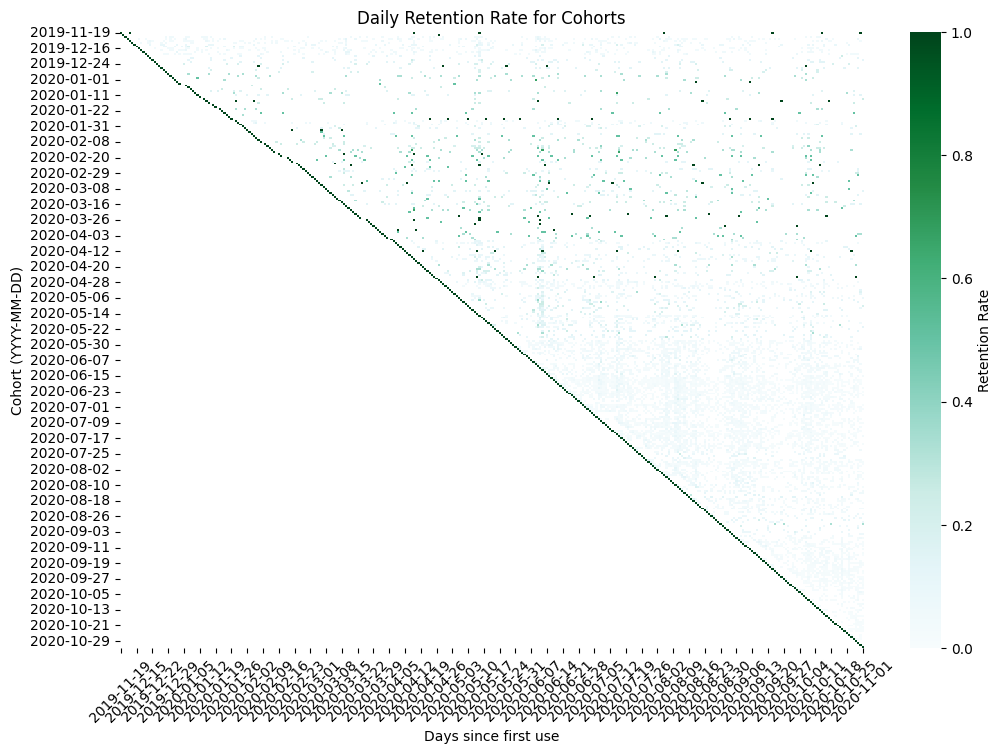

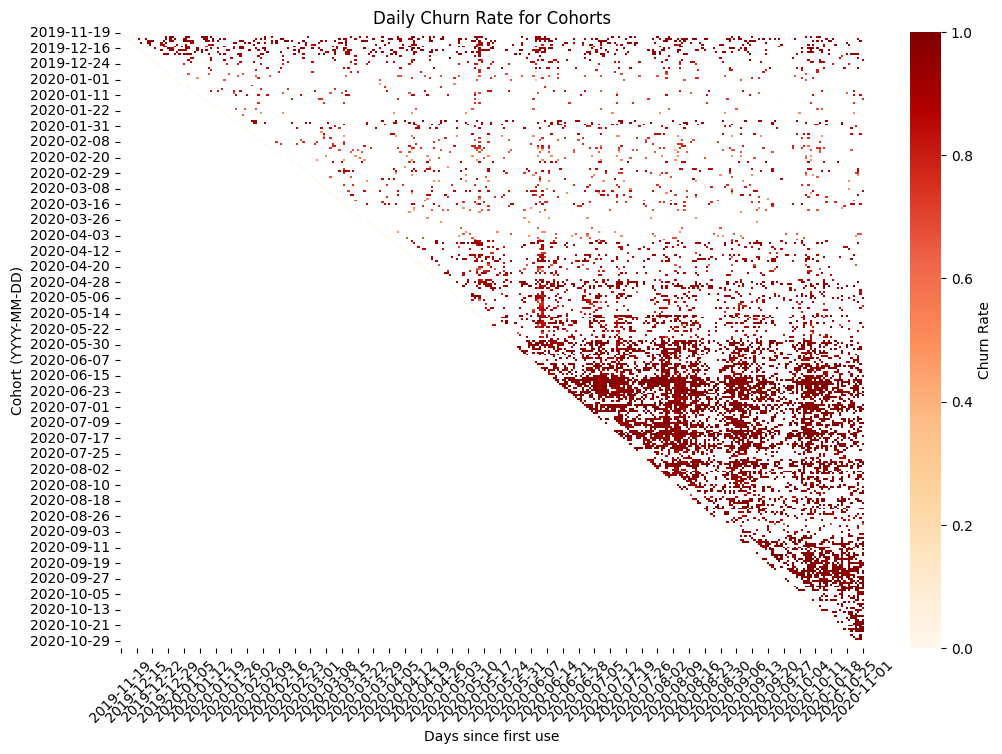

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Simulación de carga de datos
# fees= pd.read_csv('./data/extract - fees - data analyst - .csv')
# cash_request= pd.read_csv('./data/extract - cash request - data analyst.csv')

# Copia de los datos
cr = cash_request.copy()
cr = cr[['amount', 'created_at', 'user_id', 'deleted_account_id', 'transfer_type']]

# Convertir 'created_at' a datetime
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr['created_at'] = cr['created_at'].dt.tz_localize(None)

# Rellenar user_id con deleted_account_id donde sea NaN
cr['user_id'] = cr['user_id'].combine_first(cr['deleted_account_id'])
cr.drop(columns=['deleted_account_id'], inplace=True)

# Crear Cohorte Diaria (Primer día de actividad por usuario)
cr['Cohort'] = cr.groupby('user_id')['created_at'].transform('min').dt.to_period('D')

# Extraer día exacto para seguimiento diario
cr['Day'] = cr['created_at'].dt.to_period('D')

# 🏆 **Calcular el número de clientes iniciales en cada cohorte**
cohort_initial_sizes = cr.groupby('Cohort').agg(
    Number_of_initial_customers=('user_id', 'nunique')
).reset_index()

# 📊 **Calcular la retención diaria** (Número de usuarios activos por cohorte y día)
cohort_daily_sizes = cr.groupby(['Cohort', 'Day']).agg(
    Number_of_customers=('user_id', 'nunique')
).reset_index()

# 🎯 **Pivot Table: Retención Diaria por Cohorte**
retention_daily = cohort_daily_sizes.pivot(index='Cohort', columns='Day', values='Number_of_customers')

# Normalizar la retención dividiendo por el número de clientes iniciales de la cohorte
retention_daily = retention_daily.div(cohort_initial_sizes.set_index('Cohort')['Number_of_initial_customers'], axis=0)

# 📊 **Visualización: Heatmap de la Retención Diaria por Cohorte**
plt.figure(figsize=(12, 8))
plt.title('Daily Retention Rate for Cohorts')
sns.heatmap(data=retention_daily,
            annot=False,  # Cambiar a True si quieres los valores numéricos
            fmt='.0%',  
            vmin=0.0,
            vmax=1.0,
            cmap='BuGn',
            cbar_kws={'label': 'Retention Rate'})

plt.xlabel('Days since first use')
plt.ylabel('Cohort (YYYY-MM-DD)')
plt.xticks(rotation=45)
plt.show()

# 🎯 **Calcular la Tasa de Churn Diaria** (1 - Retención)
churn_daily = 1 - retention_daily

# 📊 **Visualización: Heatmap del Churn Diario**
plt.figure(figsize=(12, 8))
plt.title('Daily Churn Rate for Cohorts')
sns.heatmap(data=churn_daily,
            annot=False,  
            fmt='.0%',  
            vmin=0.0,
            vmax=1.0,
            cmap='OrRd',
            cbar_kws={'label': 'Churn Rate'})

plt.xlabel('Days since first use')
plt.ylabel('Cohort (YYYY-MM-DD)')
plt.xticks(rotation=45)
plt.show()


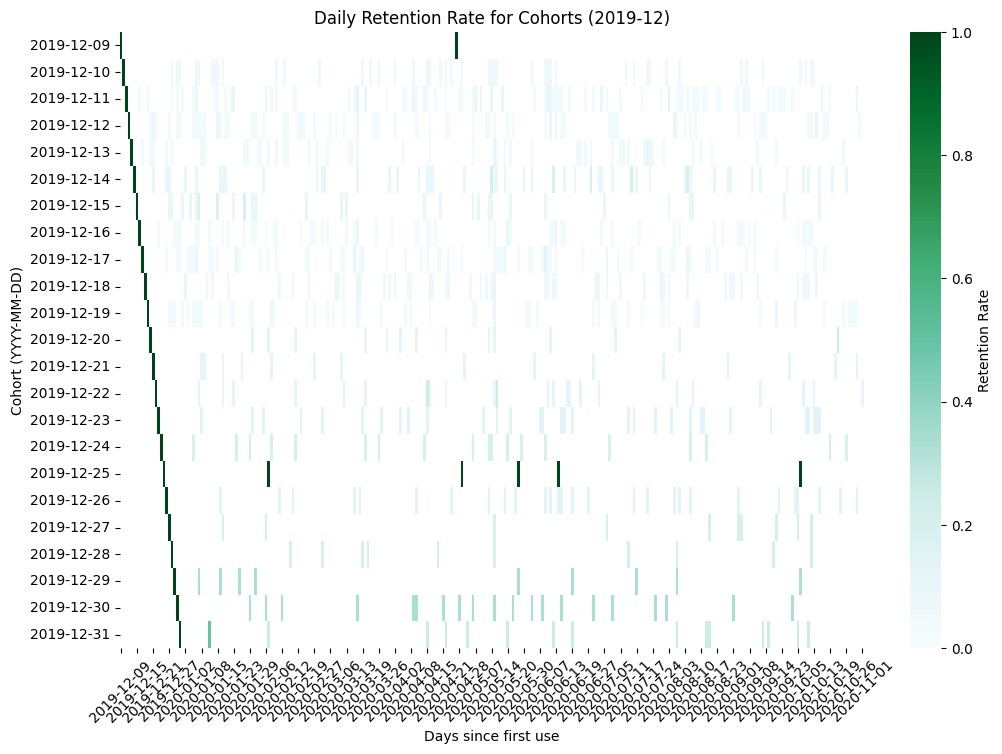

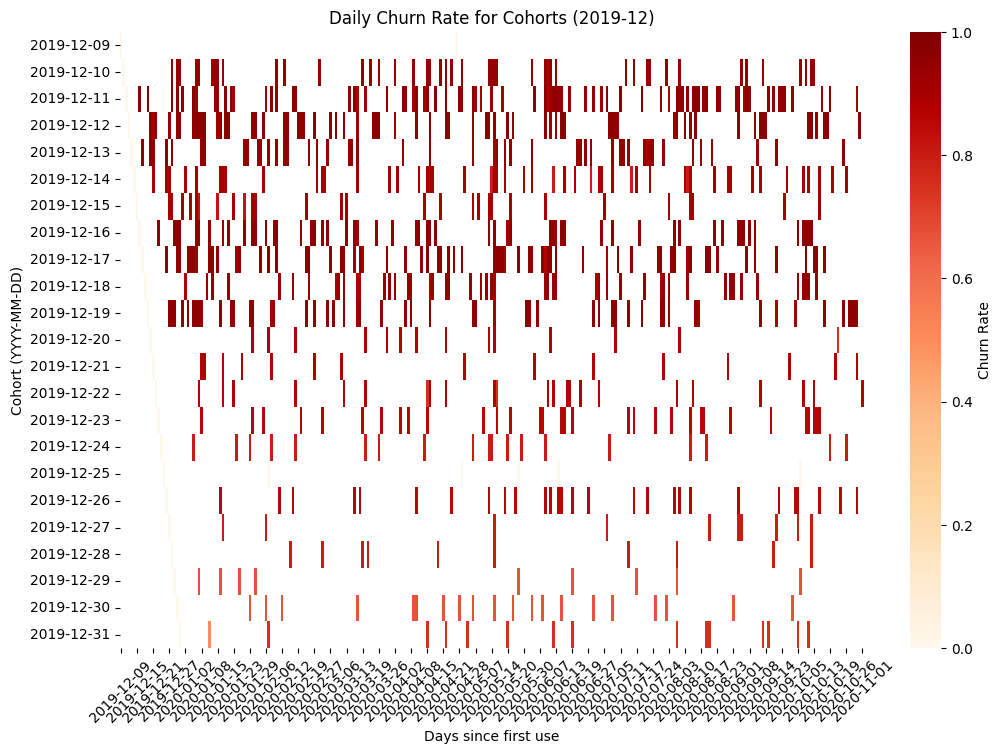

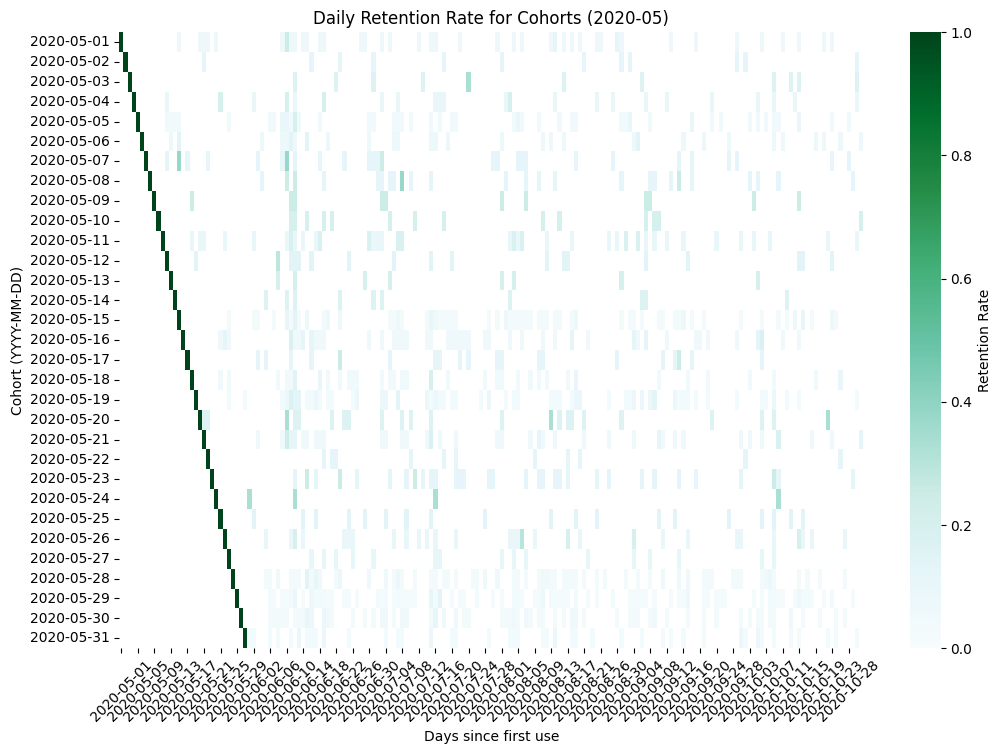

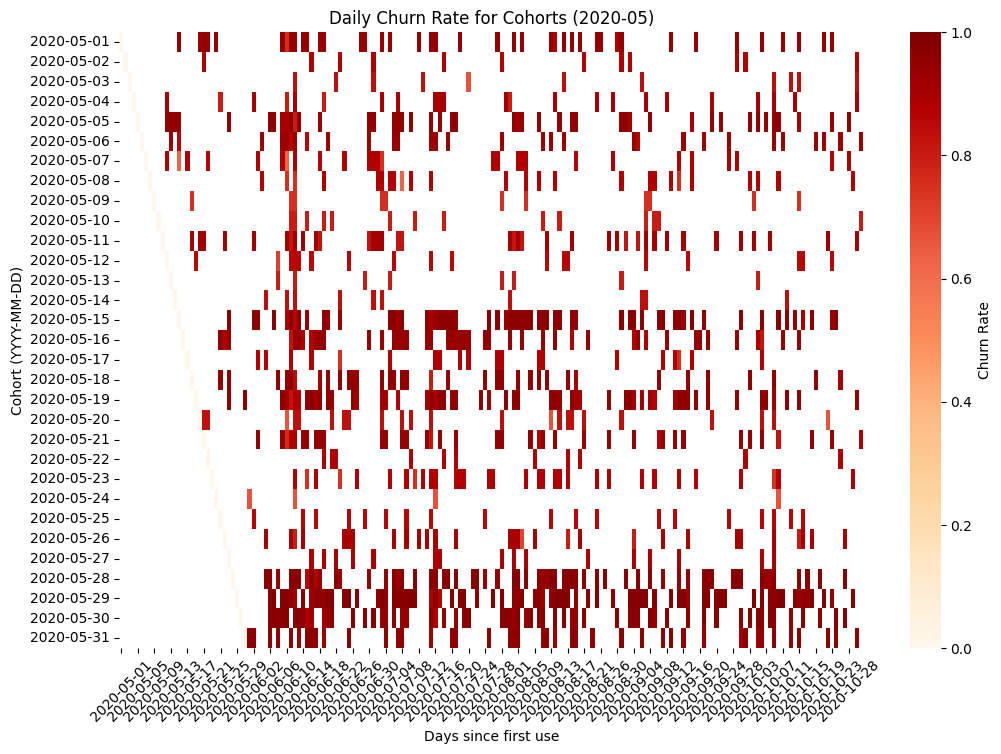

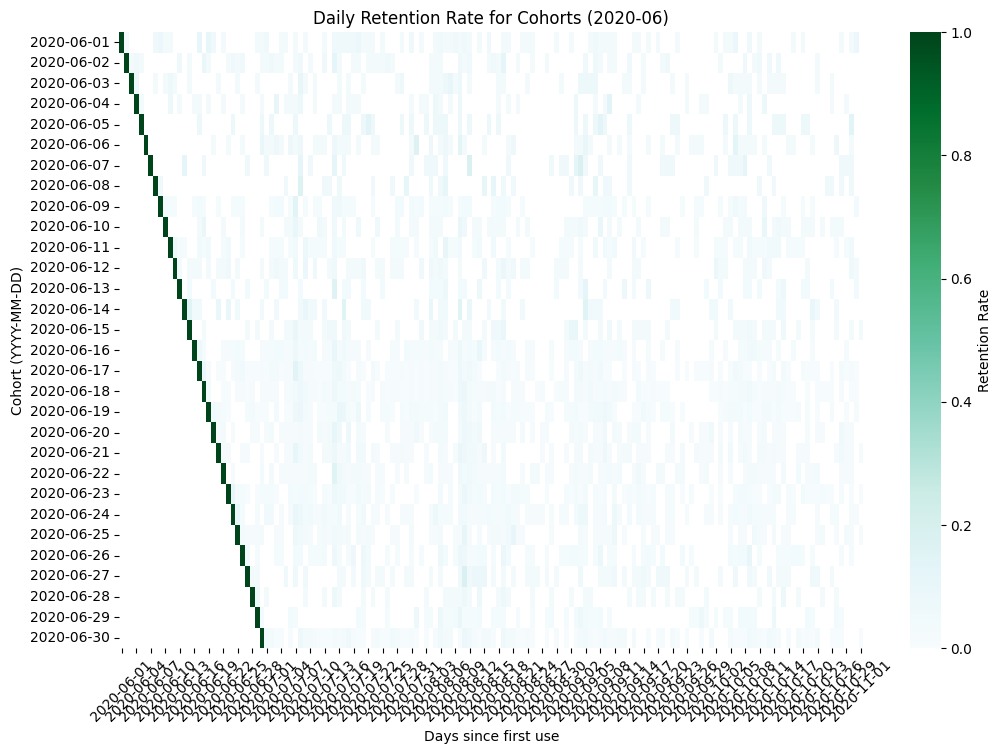

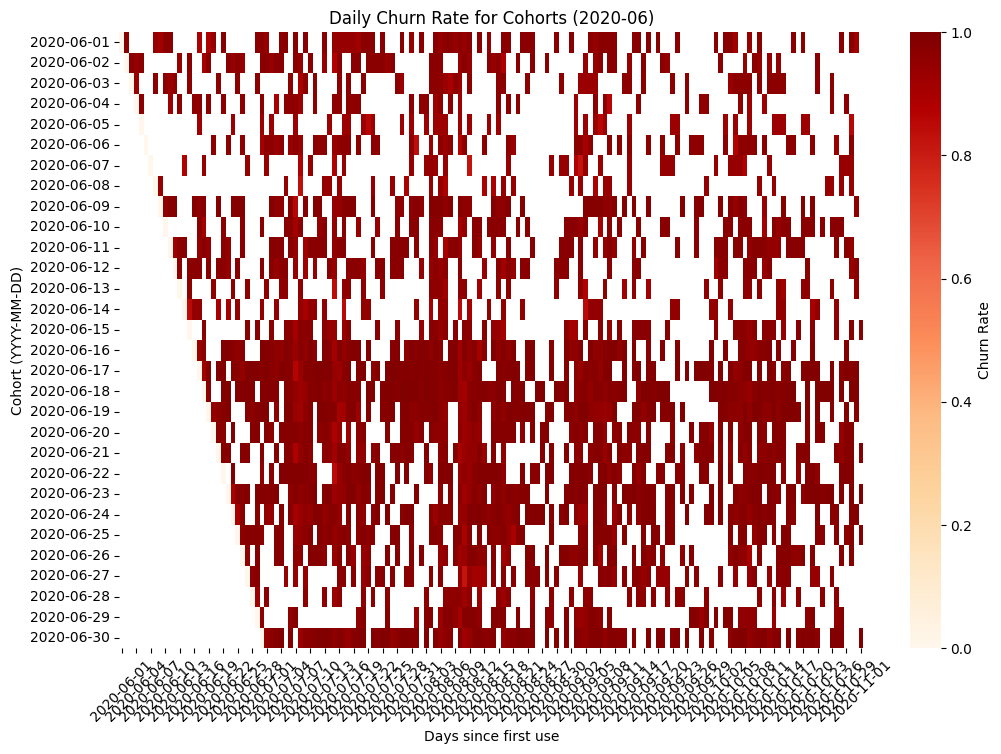

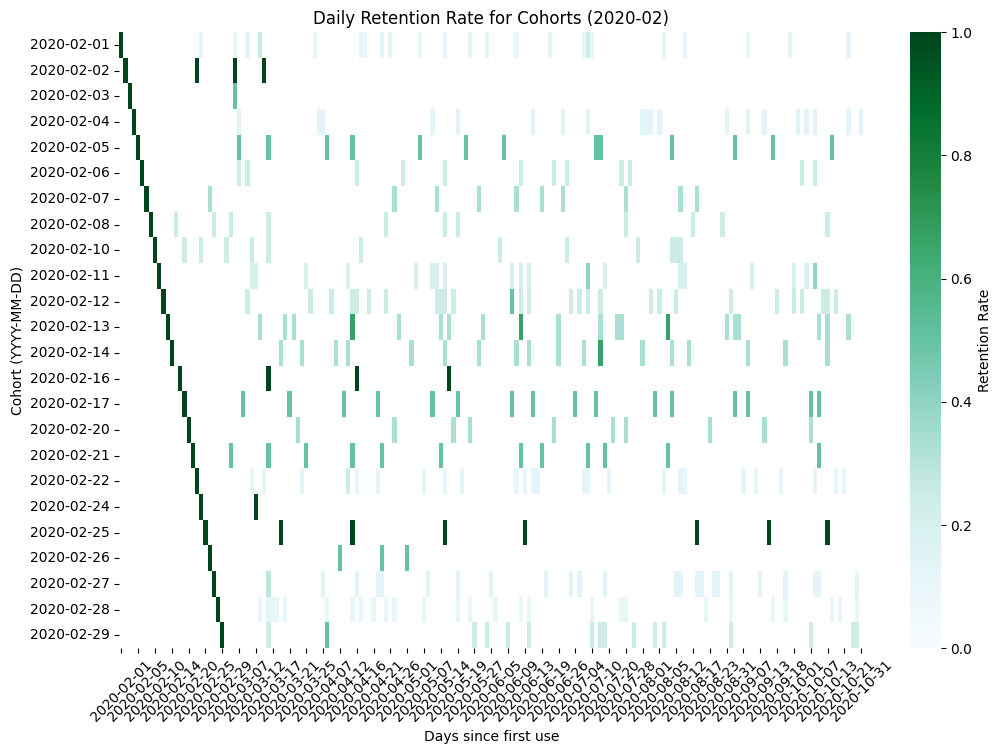

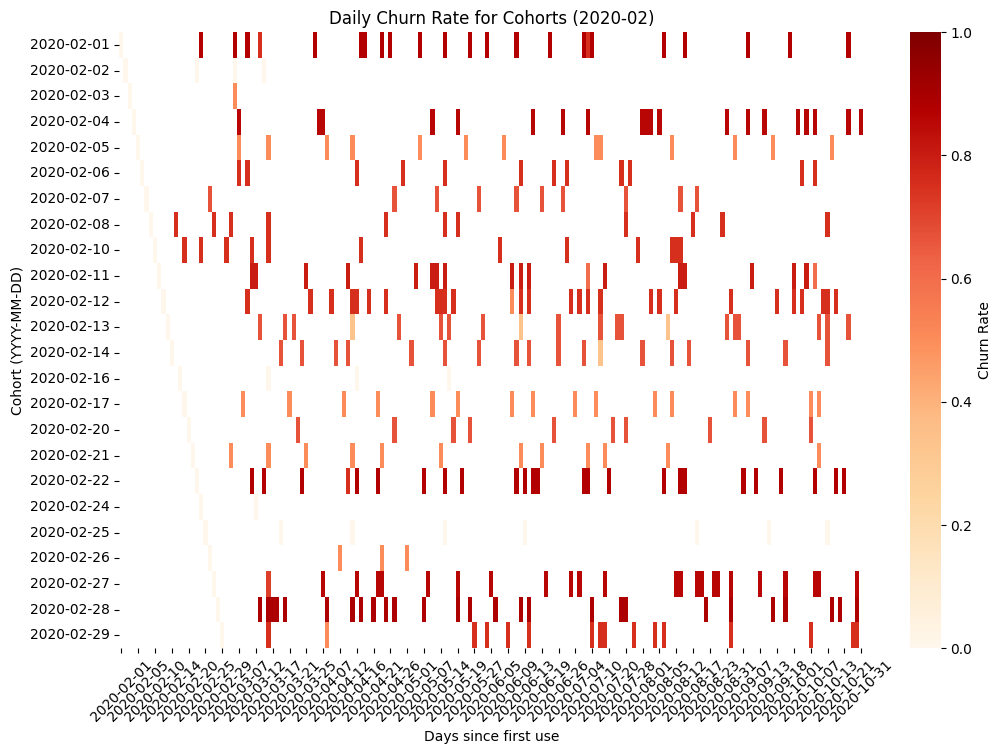

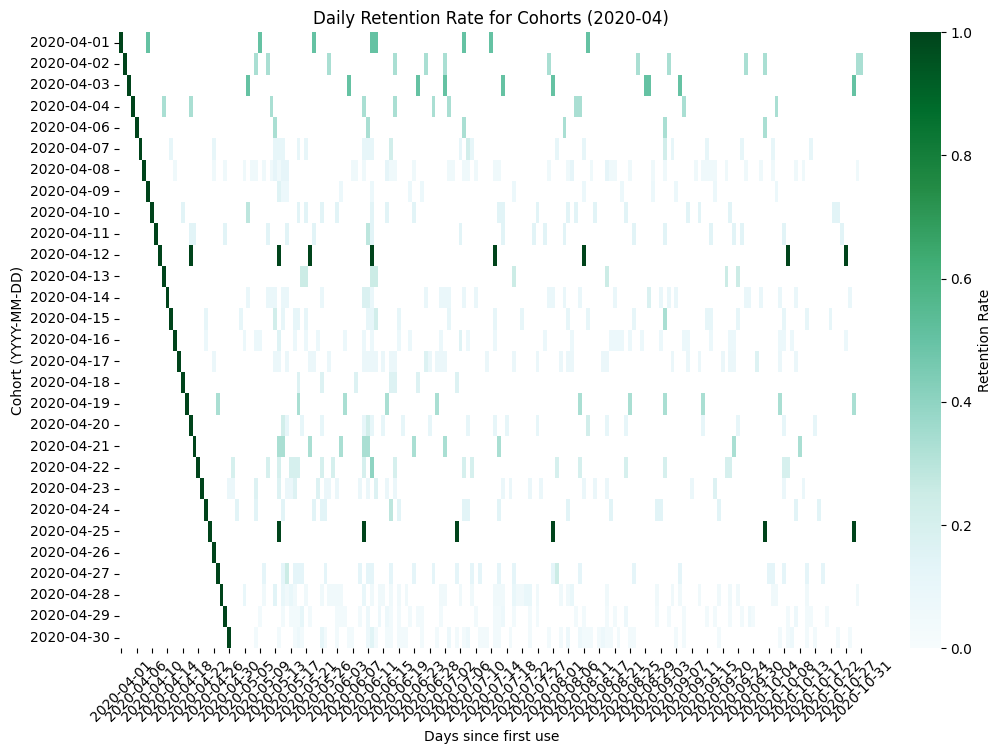

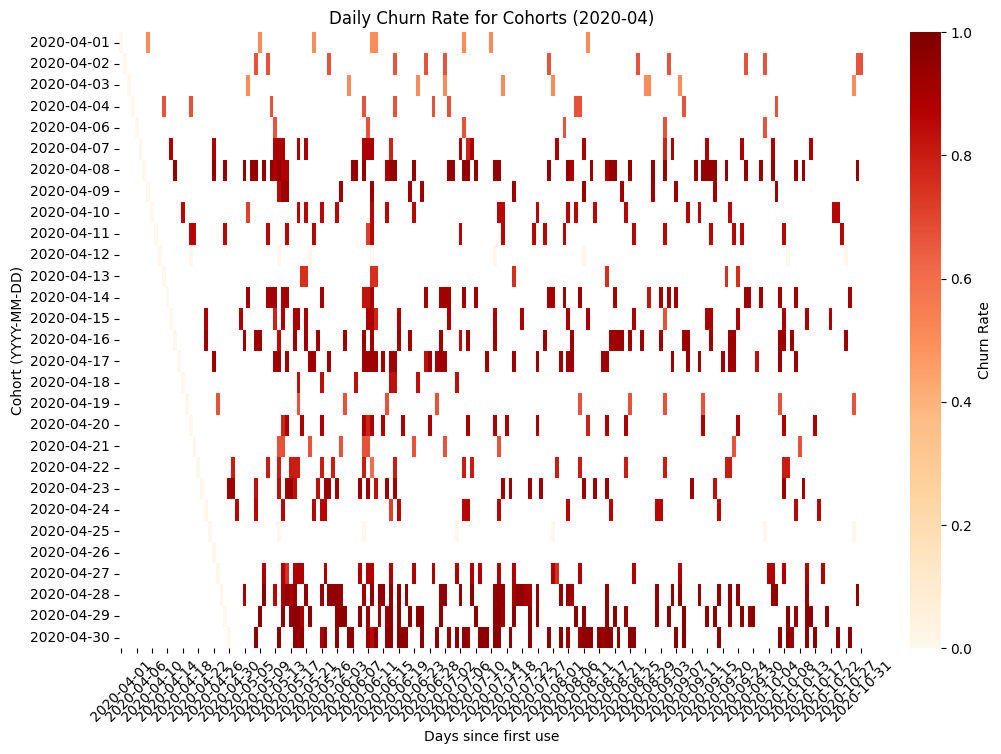

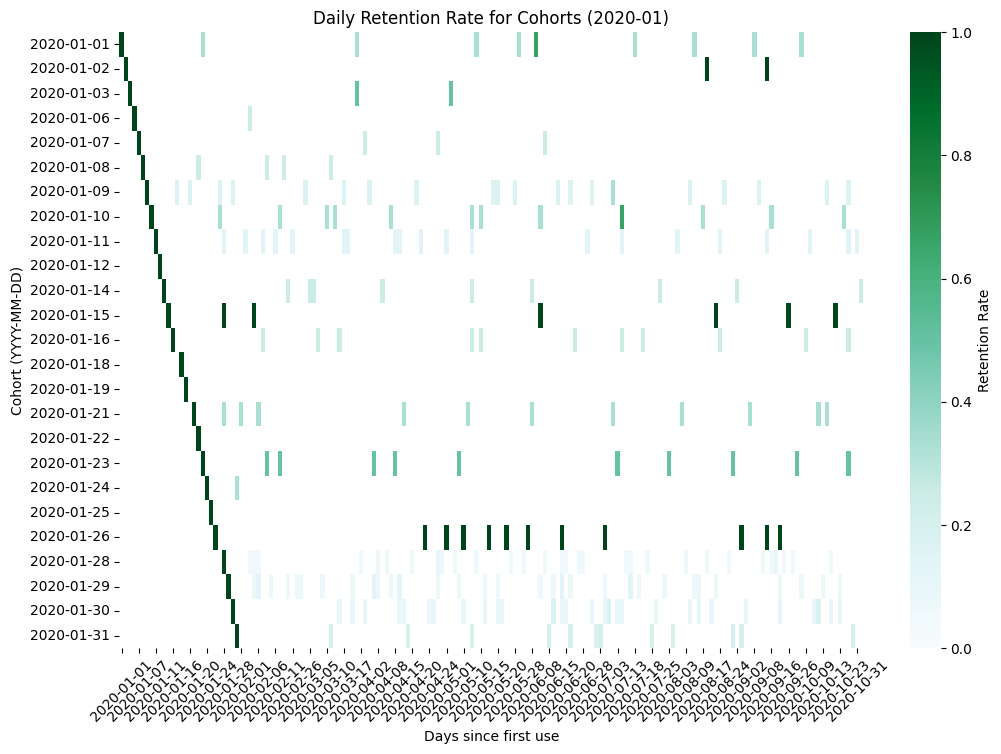

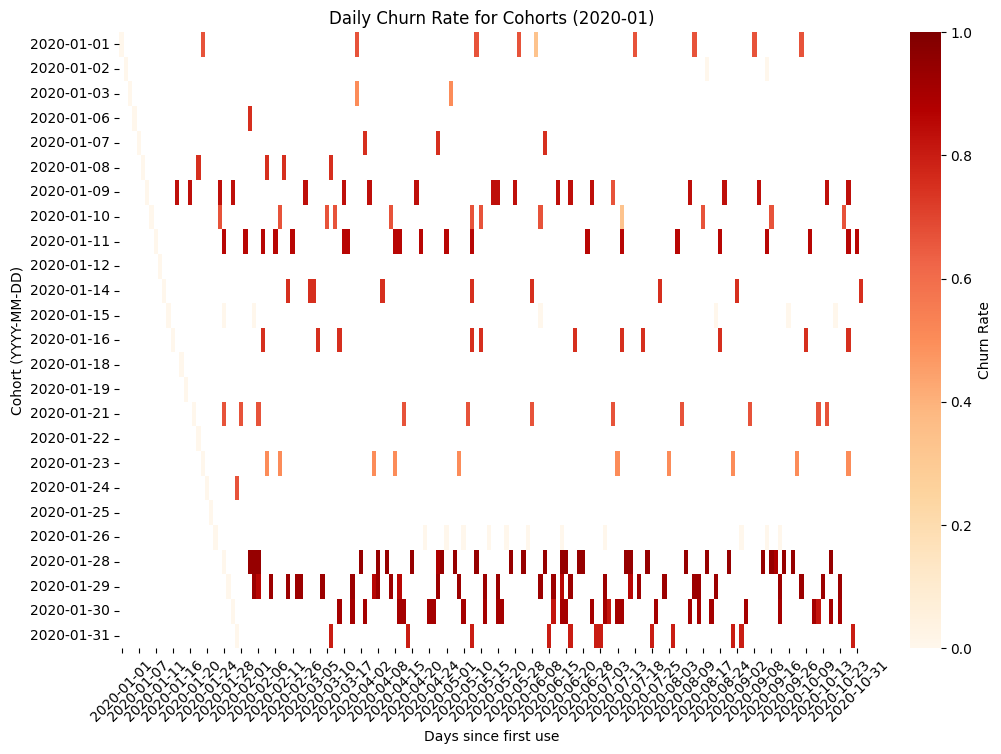

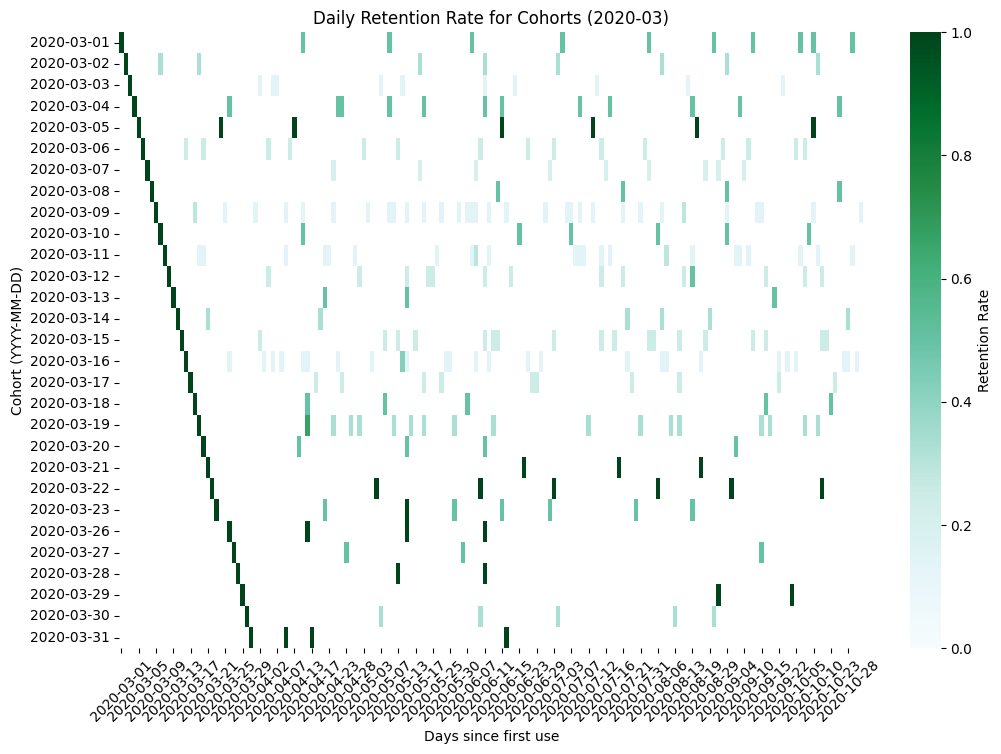

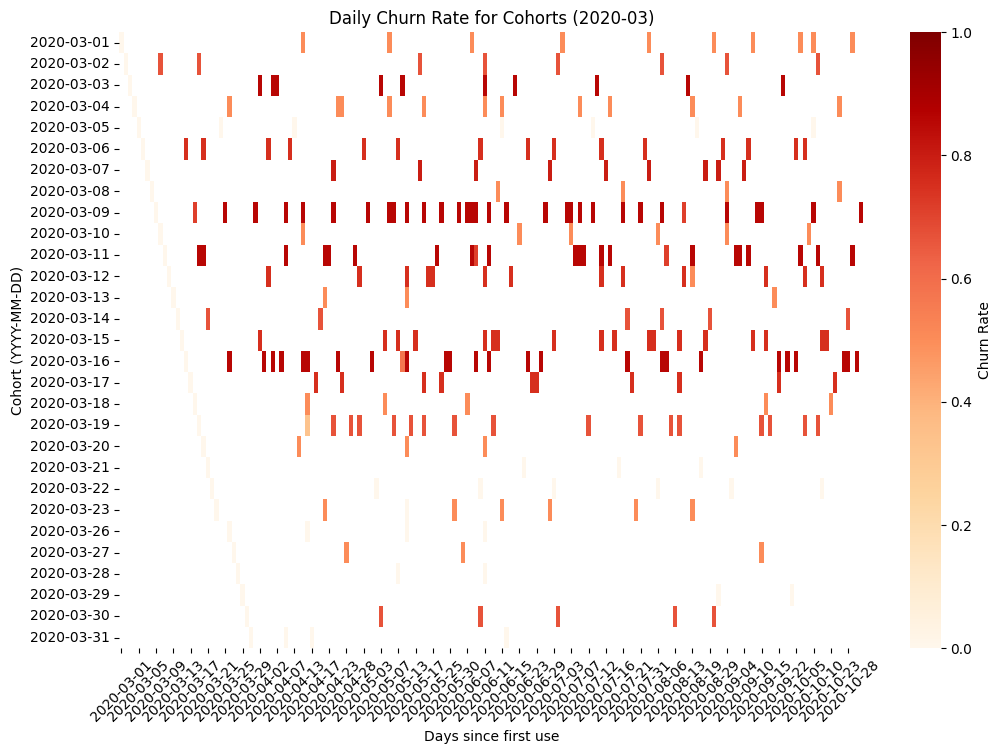

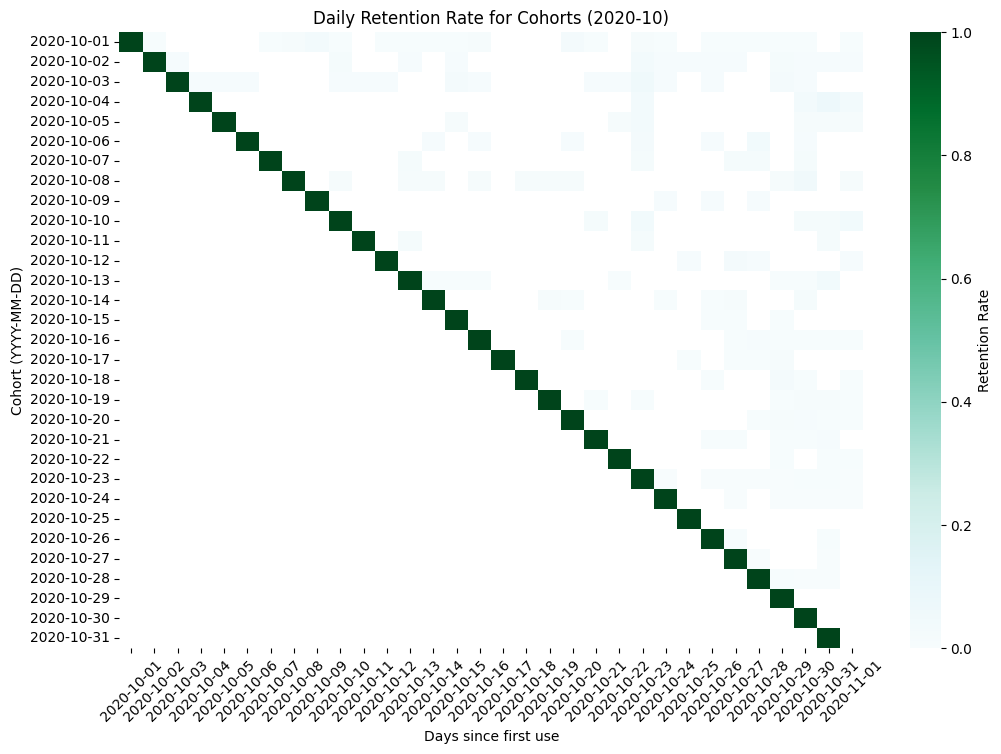

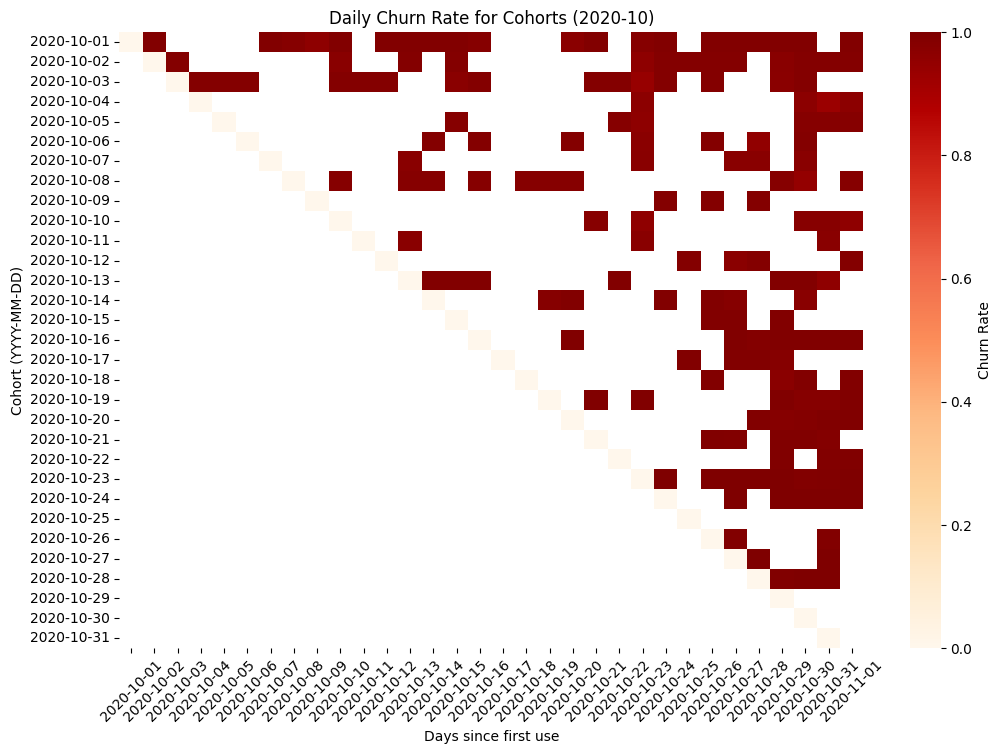

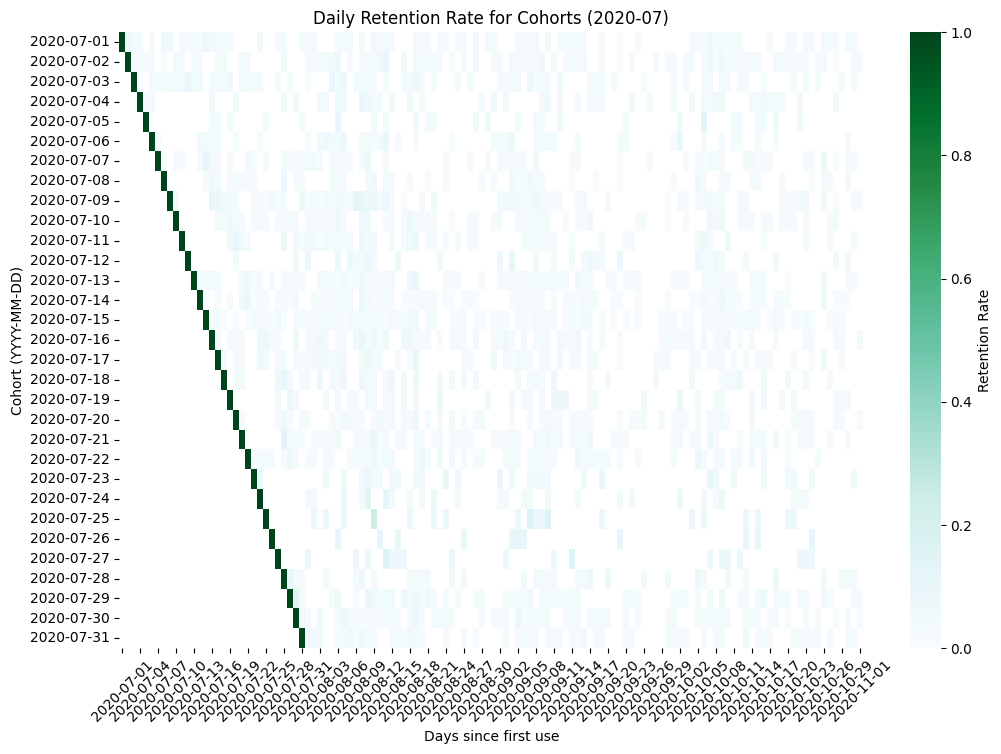

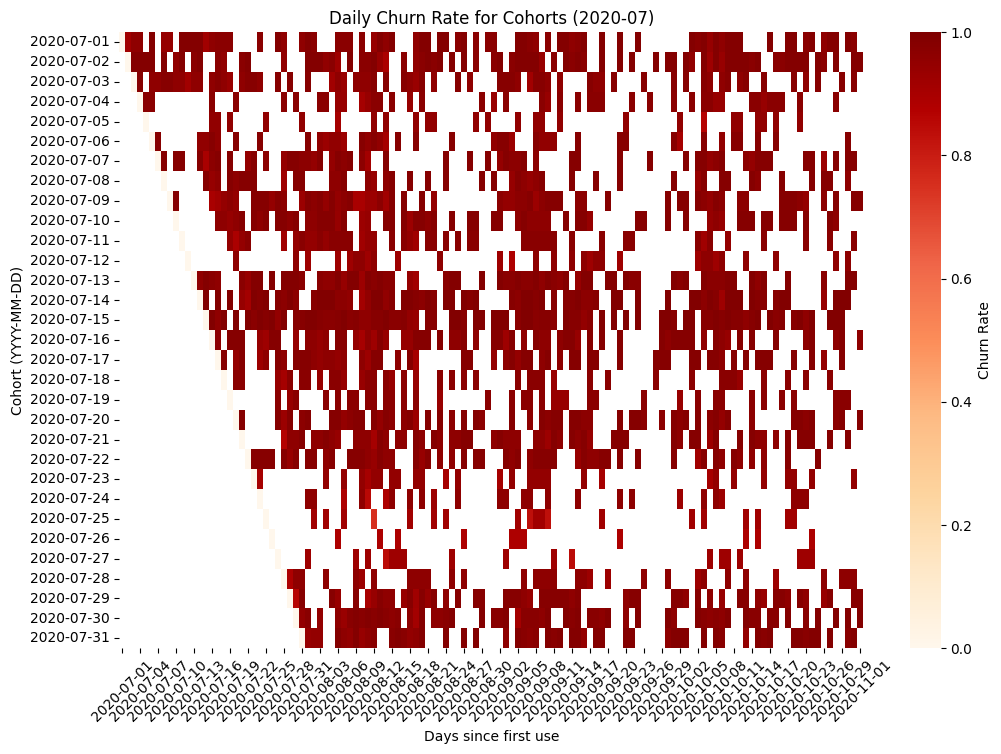

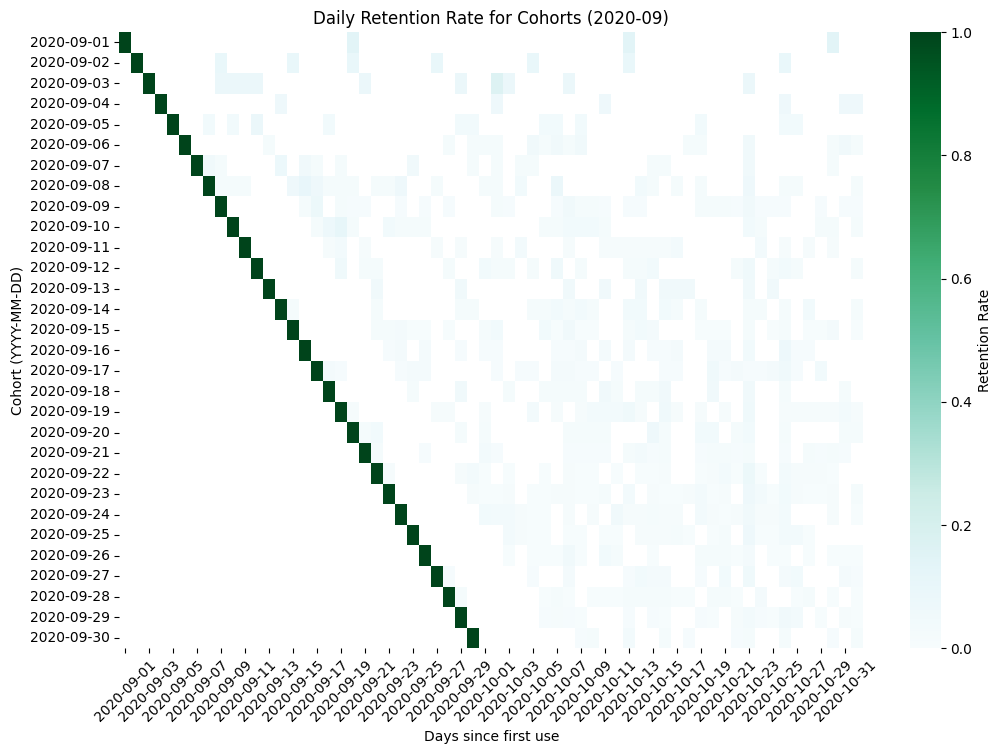

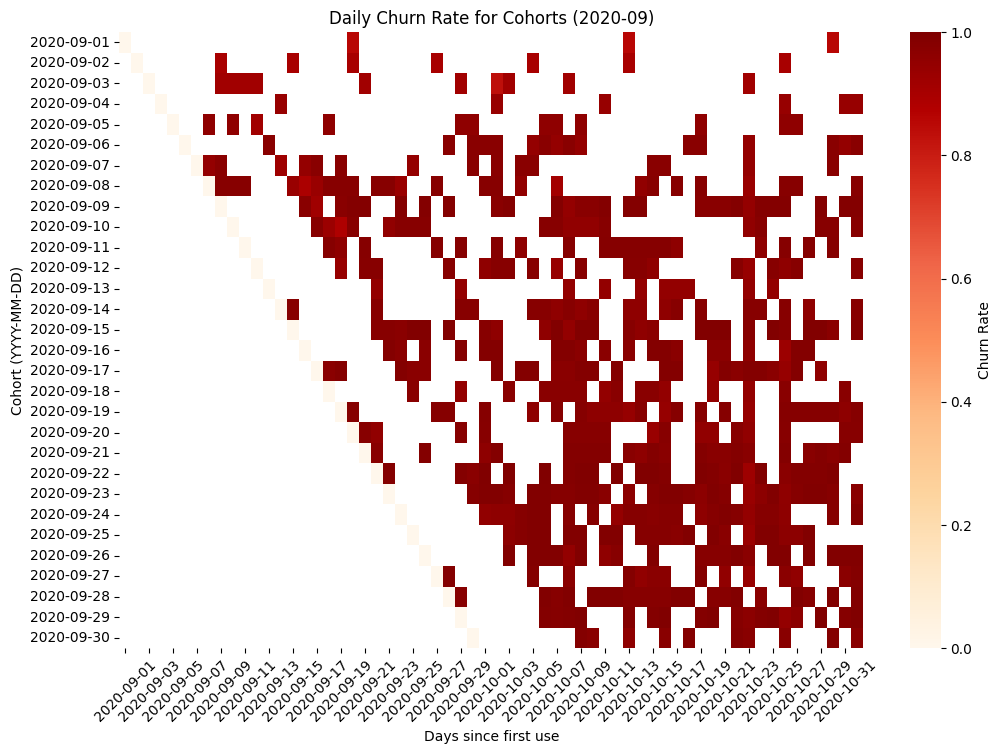

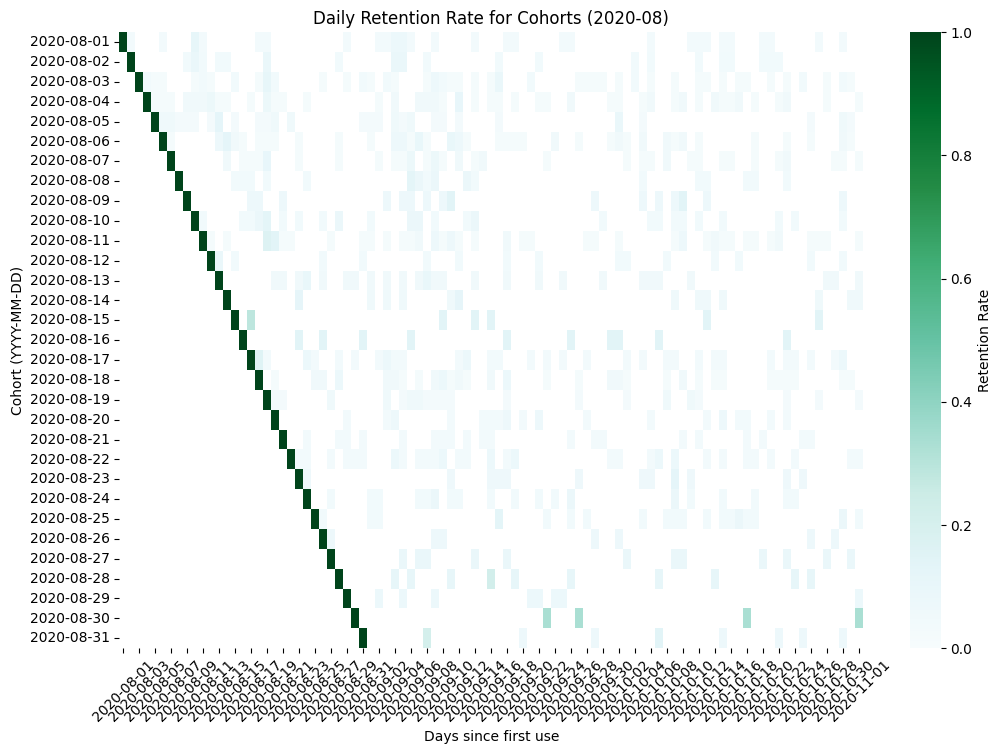

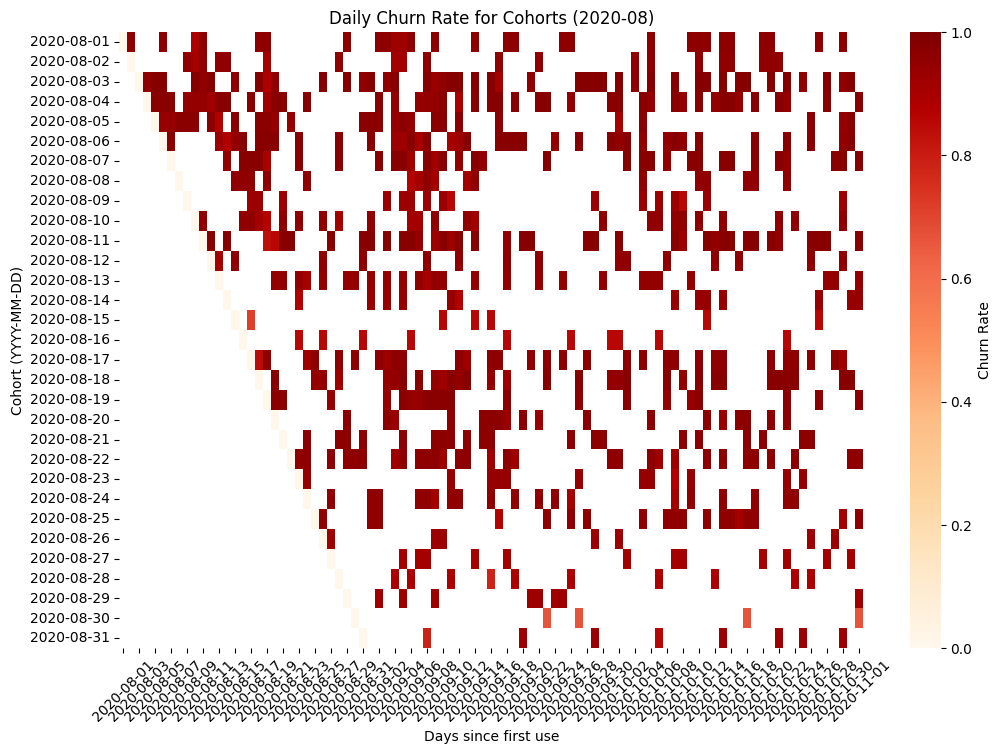

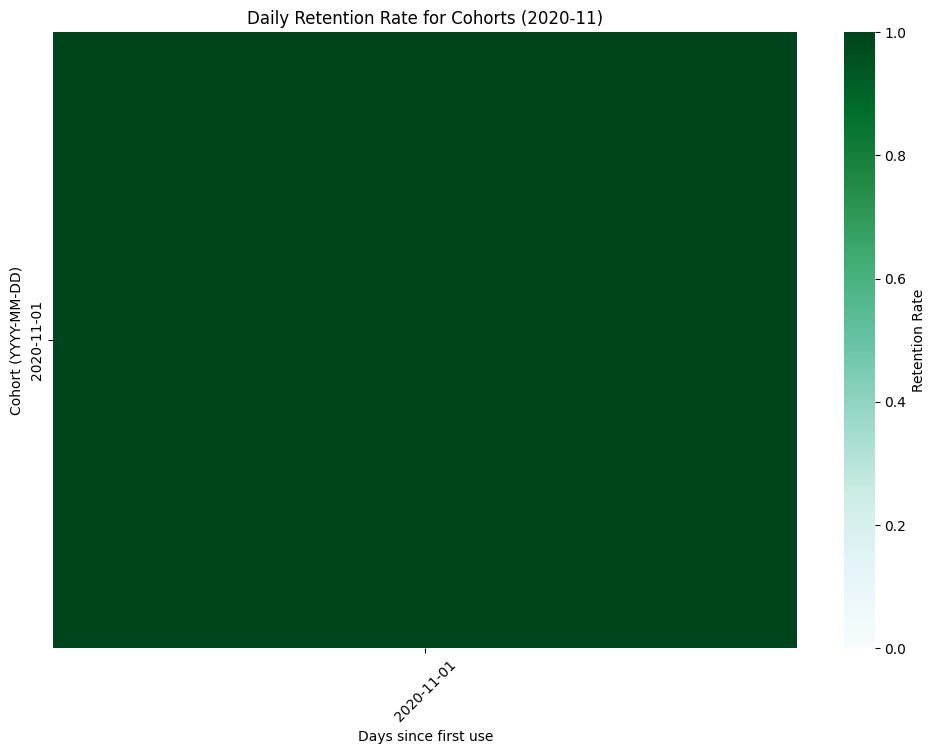

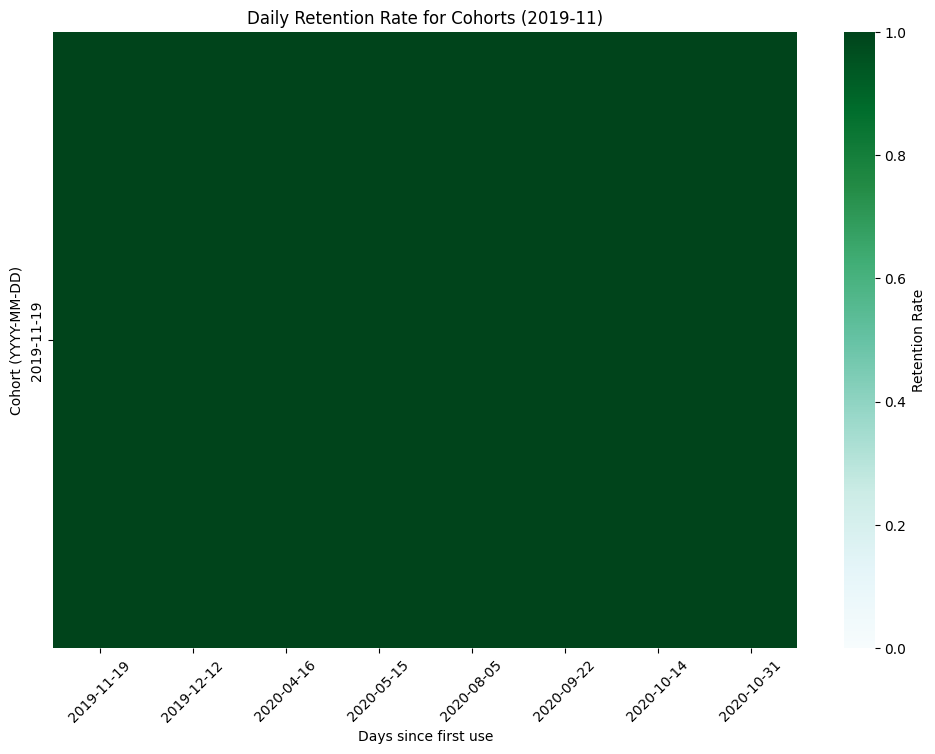

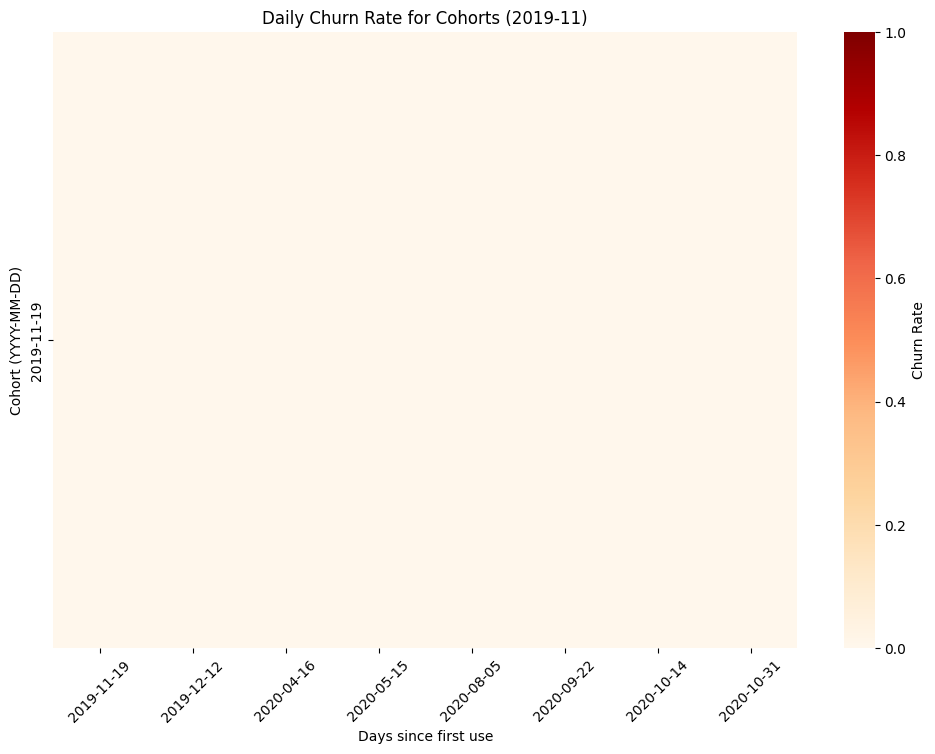

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Convertir 'created_at' a datetime y quitar timezone
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr['created_at'] = cr['created_at'].dt.tz_localize(None)

# Crear Cohorte Diaria (Primer día de actividad por usuario)
cr['Cohort'] = cr.groupby('user_id')['created_at'].transform('min').dt.to_period('D')

# Extraer mes y día exacto
cr['Month'] = cr['created_at'].dt.to_period('M')
cr['Day'] = cr['created_at'].dt.to_period('D')

# Obtener todos los meses únicos en el dataset
all_months = cr['Month'].unique()

# 📌 **Generar Heatmaps Mes a Mes**
for selected_month in all_months:
    # Filtrar solo las cohortes que comenzaron en el mes actual
    cr_mes = cr[cr['Cohort'].astype(str).str.startswith(str(selected_month))].copy()

    # 🏆 **Calcular el número de clientes iniciales en cada cohorte diaria**
    cohort_initial_sizes = cr_mes.groupby('Cohort').agg(
        Number_of_initial_customers=('user_id', 'nunique')
    ).reset_index()

    # 📊 **Calcular la retención diaria** (Número de usuarios activos por cohorte y día)
    cohort_daily_sizes = cr_mes.groupby(['Cohort', 'Day']).agg(
        Number_of_customers=('user_id', 'nunique')
    ).reset_index()

    # 🎯 **Pivot Table: Retención Diaria por Cohorte**
    retention_daily = cohort_daily_sizes.pivot(index='Cohort', columns='Day', values='Number_of_customers')

    # Normalizar la retención dividiendo por el número de clientes iniciales de la cohorte
    retention_daily = retention_daily.div(cohort_initial_sizes.set_index('Cohort')['Number_of_initial_customers'], axis=0)

    # 📊 **Visualización: Heatmap de la Retención Diaria**
    plt.figure(figsize=(12, 8))
    plt.title(f'Daily Retention Rate for Cohorts ({selected_month})')
    sns.heatmap(data=retention_daily,
                annot=False,  # Cambiar a True si quieres los valores numéricos
                fmt='.0%',  
                vmin=0.0,
                vmax=1.0,
                cmap='BuGn',
                cbar_kws={'label': 'Retention Rate'})

    plt.xlabel('Days since first use')
    plt.ylabel('Cohort (YYYY-MM-DD)')
    plt.xticks(rotation=45)
    plt.show()

    # 🎯 **Calcular la Tasa de Churn Diaria** (1 - Retención)
    churn_daily = 1 - retention_daily

    # 📊 **Visualización: Heatmap del Churn Diario**
    plt.figure(figsize=(12, 8))
    plt.title(f'Daily Churn Rate for Cohorts ({selected_month})')
    sns.heatmap(data=churn_daily,
                annot=False,  
                fmt='.0%',  
                vmin=0.0,
                vmax=1.0,
                cmap='OrRd',
                cbar_kws={'label': 'Churn Rate'})

    plt.xlabel('Days since first use')
    plt.ylabel('Cohort (YYYY-MM-DD)')
    plt.xticks(rotation=45)
    plt.show()


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Cargar datos
fees = pd.read_csv('./data/extract - fees - data analyst - .csv')
cash_request = pd.read_csv('./data/extract - cash request - data analyst.csv')

# Copia de seguridad
cr = cash_request.copy()
cr = cr[['amount', 'created_at', 'user_id', 'deleted_account_id', 'transfer_type']]

# Convertir 'created_at' a datetime y eliminar zona horaria si existe
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr['created_at'] = cr['created_at'].dt.tz_localize(None)

# Rellenar 'user_id' con 'deleted_account_id' donde sea NaN
cr['user_id'] = cr['user_id'].combine_first(cr['deleted_account_id'])
cr.drop(columns=['deleted_account_id'], inplace=True)

# Convertir a periodos diarios en lugar de mensuales
cr['Day'] = cr['created_at'].dt.to_period('D')  # Se usa 'D' para periodos diarios

# Calcular la cohorte diaria (primer día de uso por usuario)
cr['cohort_d'] = cr.groupby('user_id')['Day'].transform('min')

# Agrupar por cohort_d y contar usuarios iniciales
cohort_daily_initial_sizes = cr.groupby('cohort_d').agg(
    Number_of_initial_customers=('user_id', 'nunique')
).reset_index()

# Agrupar por cohort_d y Day para contar usuarios activos
cohort_daily_sizes = cr.groupby(['cohort_d', 'Day']).agg(
    Number_of_customers=('user_id', 'nunique')
).reset_index()

# Agrupar por cohort_d y Day para contar solicitudes
cohort_cash_daily = cr.groupby(['cohort_d', 'Day']).agg(
    Num_requests=('user_id', 'count')
).reset_index()

# Convertir 'Day' a datetime para cálculos correctos
cohort_daily_sizes['Day'] = cohort_daily_sizes['Day'].astype(str)
cohort_daily_sizes['Day'] = pd.to_datetime(cohort_daily_sizes['Day'])

# Calcular tasa de retención diaria
customers_daily_retention = cohort_daily_sizes.pivot(index='cohort_d', columns='Day', values='Number_of_customers')

# Dividir cada día por el número inicial de clientes en cada cohorte
customers_daily_retention = customers_daily_retention.div(
    cohort_daily_initial_sizes.set_index('cohort_d')['Number_of_initial_customers'], axis=0
)

# Convertir la tabla a formato largo para análisis de series temporales
df_retention = customers_daily_retention.reset_index().melt(id_vars=['cohort_d'], var_name='Day', value_name='Retention_Rate')

# Asegurar que 'Day' es datetime
df_retention['Day'] = pd.to_datetime(df_retention['Day'])

# Calcular la diferencia en días correctamente (desde cohort_d hasta Day)
df_retention['cohort_d'] = df_retention['cohort_d'].astype(str)  # Convertir a string para evitar errores
df_retention['cohort_d'] = pd.to_datetime(df_retention['cohort_d'])  # Convertir a datetime
df_retention['Day_Num'] = (df_retention['Day'] - df_retention['cohort_d']).dt.days

# Verificar los datos corregidos
df_retention


cohort_d        Day  Retention_Rate  Day_Num
0      2019-11-19 2019-11-19             1.0        0
1      2019-12-09 2019-11-19             NaN      -20
2      2019-12-10 2019-11-19             NaN      -21
3      2019-12-11 2019-11-19             NaN      -22
4      2019-12-12 2019-11-19             NaN      -23
...           ...        ...             ...      ...
104275 2020-10-28 2020-11-01             NaN        4
104276 2020-10-29 2020-11-01             NaN        3
104277 2020-10-30 2020-11-01             NaN        2
104278 2020-10-31 2020-11-01             NaN        1
104279 2020-11-01 2020-11-01             1.0        0

[104280 rows x 4 columns]

GRAFICO DE DISPERSION

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Convertir cohort_d a datetime para agrupar por frecuencia de tiempo
df_retention["cohort_d"] = pd.to_datetime(df_retention["cohort_d"])

# Agrupar por día de cohorte y calcular la media de la Retention Rate
df_daily_mean = df_retention.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
    Mean_Retention_Rate=("Retention_Rate", "mean")
).reset_index()

# 📊🚀 Gráfico de Dispersión con la Media Diaria de la Retention Rate
plt.figure(figsize=(15, 6))

# Graficar la media diaria de la retención para TODAS las cohortes en un solo gráfico
plt.scatter(df_daily_mean["cohort_d"], df_daily_mean["Mean_Retention_Rate"], alpha=0.7, color="blue")

plt.title("Daily Retention Rate (Averaged by Day)")
plt.xlabel("Cohort Date (YYYY-MM-DD)")  # Cohorte diaria en el eje X
plt.ylabel("Average Retention Rate")  # Tasa de retención media en el eje Y
plt.xticks(rotation=90, fontsize=8)  # Rotar etiquetas del eje X para mejor visualización
plt.grid(alpha=0.3)
plt.show()


HEATMAP DIARIO DE UN MES EN CONCRETO

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# mes específico a analizar (AÑO-MES)
mes_especifico = "2020-02" 


df_daily_mean["cohort_d"] = pd.to_datetime(df_daily_mean["cohort_d"])

# Filtrar solo el mes específico
df_mes = df_daily_mean[df_daily_mean["cohort_d"].dt.strftime("%Y-%m") == mes_especifico].copy()

# Extraer el día del mes
df_mes["Día"] = df_mes["cohort_d"].dt.day

# Crear una tabla pivote con la media de Retention Rate diaria
retention_pivot = df_mes.pivot(index="Día", values="Mean_Retention_Rate", columns="cohort_d")

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Heatmap
sns.heatmap(
    retention_pivot, 
    cmap="coolwarm", 
    annot=True, 
    fmt=".2f", 
    linewidths=0.5, 
    cbar_kws={'label': 'Retention Rate Media'}
)


plt.title(f"Heatmap de la Media Diaria de Retention Rate en {mes_especifico}", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Día del Mes", fontsize=14)
plt.xticks(rotation=45)  
plt.yticks(rotation=0)  
plt.show()



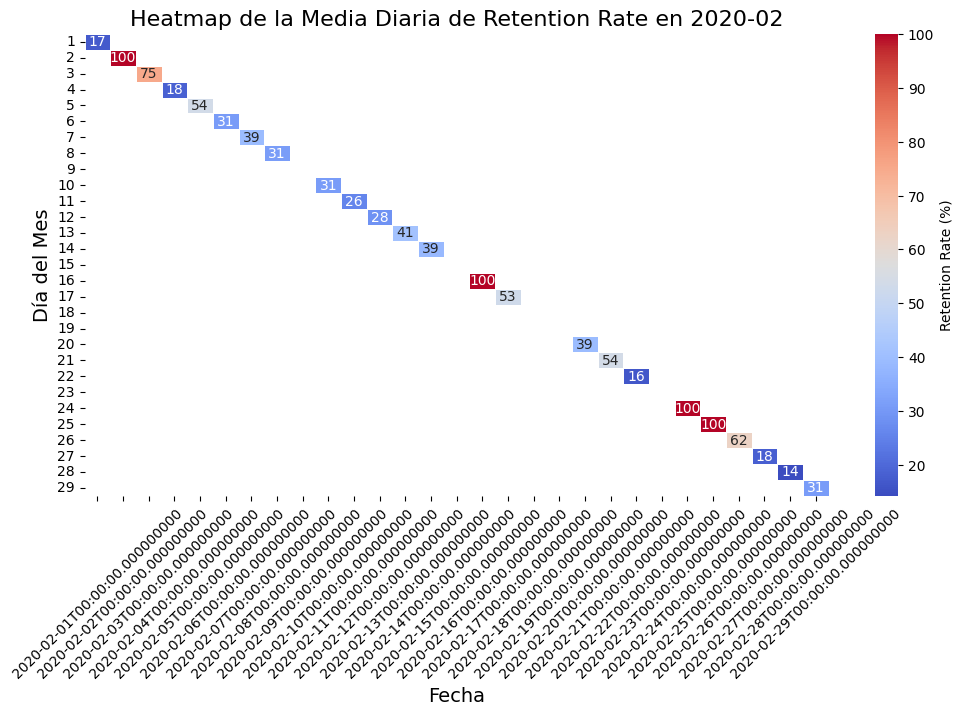

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#mes específico a analizar (AÑO-MES)
mes_especifico = "2020-02"

# Convertir cohort_d a datetime 
df_daily_mean["cohort_d"] = pd.to_datetime(df_daily_mean["cohort_d"])

# Filtrar solo el mes específico
df_mes = df_daily_mean[df_daily_mean["cohort_d"].dt.strftime("%Y-%m") == mes_especifico].copy()

# Extraer el día del mes
df_mes["Día"] = df_mes["cohort_d"].dt.day

# Convertir la tasa de retención a porcentaje (multiplicar por 100)
df_mes["Mean_Retention_Rate"] = df_mes["Mean_Retention_Rate"] * 100

# Crear una tabla pivote con la media de Retention Rate diaria
retention_pivot = df_mes.pivot(index="Día", values="Mean_Retention_Rate", columns="cohort_d")

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Crear el heatmap
sns.heatmap(
    retention_pivot, 
    cmap="coolwarm", 
    annot=True,  
    fmt=".0f", 
    linewidths=0.5, 
    cbar_kws={'label': 'Retention Rate (%)'}  
)

# Configurar títulos y etiquetas
plt.title(f"Heatmap de la Media Diaria de Retention Rate en {mes_especifico}", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Día del Mes", fontsize=14)
plt.xticks(rotation=45)  
plt.yticks(rotation=0)  
plt.show()


In [8]:
# Librerias
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Análisis de Regresión - RMSE: 0.2597, R²: 0.1458


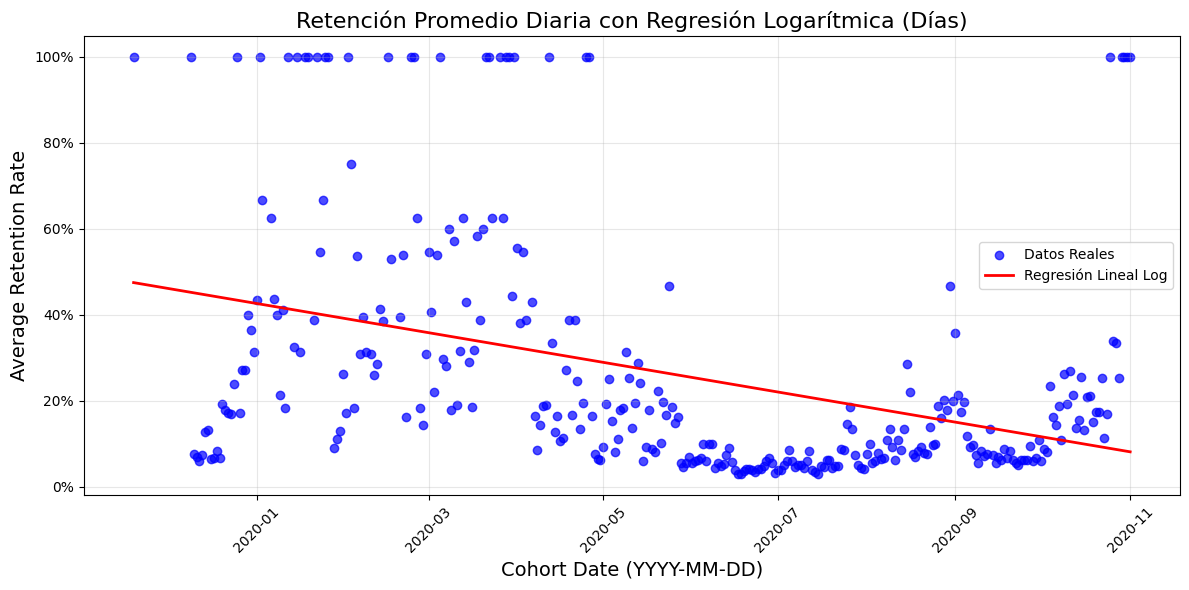

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Convertir cohort_d a datetime
df_retention["cohort_d"] = pd.to_datetime(df_retention["cohort_d"])

# Agrupar por cohorte diaria y calcular la media de la Retention Rate
df_daily_mean = df_retention.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
    Mean_Retention_Rate=("Retention_Rate", "mean")
).reset_index()

# **Eliminar valores NaN en la Retention Rate**
df_daily_mean = df_daily_mean.dropna(subset=["Mean_Retention_Rate"])

# Convertir la fecha a un número ordinal
df_daily_mean["Date_Num"] = df_daily_mean["cohort_d"].map(pd.Timestamp.toordinal)

# Frecuencia temporal por días
freq = 'D'
label = 'Días'

# Aplicar Regresión Logarítmica a la Media Diaria de Retention Rate
# Convertir fechas a formato numérico para la regresión
X = np.log(df_daily_mean[['Date_Num']].values)  
y = df_daily_mean['Mean_Retention_Rate'].values

# Entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Generar predicciones
df_daily_mean['Predicted'] = model.predict(X)

# Calcular métricas de la regresión
rmse = np.sqrt(mean_squared_error(y, df_daily_mean['Predicted']))
r2 = r2_score(y, df_daily_mean['Predicted'])

print(f"Análisis de Regresión - RMSE: {rmse:.4f}, R²: {r2:.4f}")

#  Crear el gráfico de dispersión con la regresión
plt.figure(figsize=(12, 6))

# Gráfico de dispersión con la media diaria de retención
plt.scatter(df_daily_mean["cohort_d"], df_daily_mean["Mean_Retention_Rate"], alpha=0.7, label="Datos Reales", color="blue")

# Curva de regresión logarítmica
plt.plot(df_daily_mean["cohort_d"], df_daily_mean["Predicted"], color="red", label="Regresión Lineal Log", linewidth=2)

plt.title(f'Retención Promedio Diaria con Regresión Logarítmica ({label})', fontsize=16)
plt.xlabel("Cohort Date (YYYY-MM-DD)", fontsize=14)
plt.ylabel("Average Retention Rate", fontsize=14)
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
plt.xticks(rotation=45, fontsize=10)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Convertir cohort_d a datetime
df_retention["cohort_d"] = pd.to_datetime(df_retention["cohort_d"])

# Agrupar por cohorte diaria y calcular la media de la Retention Rate
df_daily_mean = df_retention.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
    Mean_Retention_Rate=("Retention_Rate", "mean")
).reset_index()

# **Eliminar valores NaN en la Retention Rate**
df_daily_mean = df_daily_mean.dropna(subset=["Mean_Retention_Rate"])

# Convertir la fecha a un número ordinal
df_daily_mean["Date_Num"] = df_daily_mean["cohort_d"].map(pd.Timestamp.toordinal)

# Determinar el origen dinámico basado en el primer día de los datos
origin_date = df_daily_mean["cohort_d"].min()
freq = 'D'
results = []

# Aplicar Regresión Polinómica de Diferentes Grados
plt.figure(figsize=(12, 6))

# x = Fechas ordinales, y = Retention Rate Media
X = df_daily_mean[['Date_Num']].values
y = df_daily_mean['Mean_Retention_Rate'].values

# Escalar las fechas ordinales
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Generar un rango continuo de fechas para la predicción
date_range = np.linspace(df_daily_mean['Date_Num'].min(), df_daily_mean['Date_Num'].max(), 500).reshape(-1, 1)
date_range_scaled = scaler.transform(date_range)

# Crear el gráfico de dispersión
plt.scatter(df_daily_mean["cohort_d"], df_daily_mean["Mean_Retention_Rate"], alpha=0.7, label="Datos Reales", color="blue")

# Probar diferentes grados de polinomio
for degree in [3, 5, 7, 8, 9, 10]:
    # Crear el modelo polinómico con el grado actual
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_scaled)

    # Entrenar el modelo de regresión polinómica
    model = LinearRegression()
    model.fit(X_poly, y)

    predictions = model.predict(X_poly)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    results.append((degree, rmse, r2))

    print(f"Grado {degree} - RMSE: {rmse:.4f}, R²: {r2:.4f}")     

    # Transformar el rango continuo de fechas
    date_range_poly = poly.transform(date_range_scaled)
    predicted_rates = model.predict(date_range_poly)

    # Reconstruir las fechas usando el rango de fechas original
    date_range_datetime = [origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in date_range.flatten()]

    # Graficar la curva de predicción
    plt.plot(date_range_datetime, predicted_rates, label=f'Grado {degree}', linewidth=2)

# Encontrar el grado con el mejor RMSE y R2
optimal_rmse = min(results, key=lambda x: x[1])
optimal_r2 = max(results, key=lambda x: x[2])

print("\nResultados:")
print(f"Mejor RMSE en grado {optimal_rmse[0]}: {optimal_rmse[1]:.4f}")
print(f"Mejor R2 en grado {optimal_r2[0]}: {optimal_r2[2]:.4f}")

# Configurar el gráfico
plt.title('Regresión Polinómica sobre la Retention Rate Promedio Diaria', fontsize=16)
plt.xlabel('Fecha de Cohorte', fontsize=14)
plt.ylabel('Retention Rate Promedio', fontsize=14)
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Grado 3 - RMSE: 0.2240, R²: 0.3644
Grado 5 - RMSE: 0.2240, R²: 0.3647
Grado 7 - RMSE: 0.2100, R²: 0.4415
Grado 8 - RMSE: 0.2044, R²: 0.4708
Grado 9 - RMSE: 0.2032, R²: 0.4768
Grado 10 - RMSE: 0.2002, R²: 0.4925

Resultados:
Mejor RMSE en grado 10: 0.2002
Mejor R2 en grado 10: 0.4925


Grado 3 - RMSE: 0.2258, R²: 0.3545
Grado 5 - RMSE: 0.2265, R²: 0.3502
Grado 7 - RMSE: 0.2195, R²: 0.3896
Grado 8 - RMSE: 0.2111, R²: 0.4358
Grado 9 - RMSE: 0.2113, R²: 0.4344
Grado 10 - RMSE: 0.2083, R²: 0.4506

Resultados:
Mejor RMSE en grado 10: 0.2083
Mejor R2 en grado 10: 0.4506


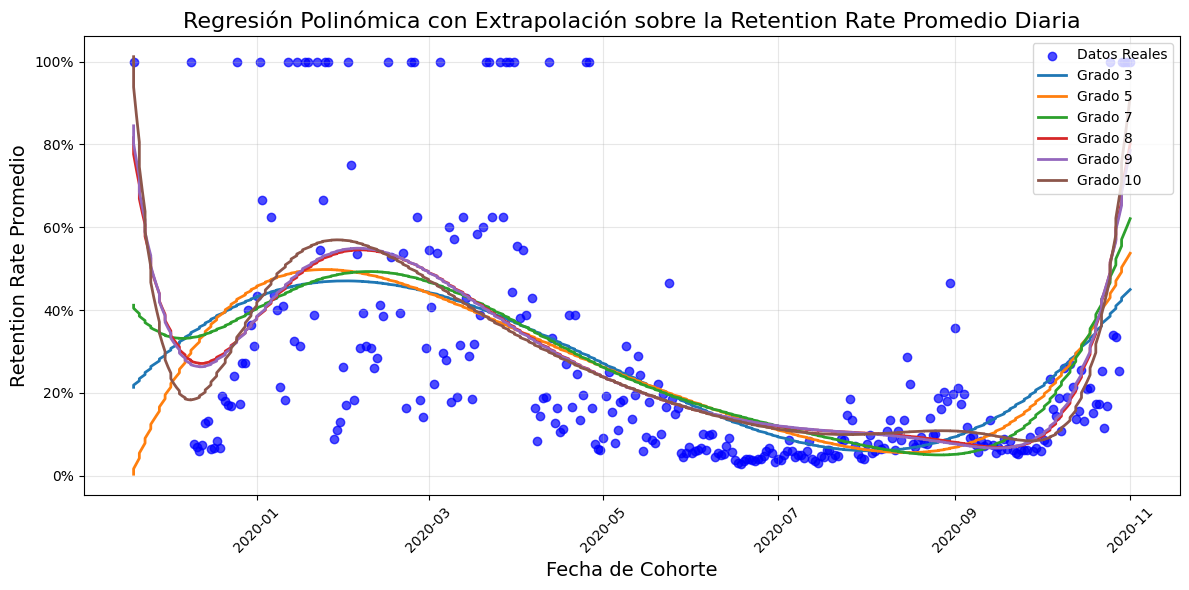

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Convertir cohort_d a datetime 
df_retention["cohort_d"] = pd.to_datetime(df_retention["cohort_d"])

# Agrupar por cohorte diaria y calcular la media de la Retention Rate
df_daily_mean = df_retention.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
    Mean_Retention_Rate=("Retention_Rate", "mean")
).reset_index()

# **Eliminar valores NaN en la Retention Rate**
df_daily_mean = df_daily_mean.dropna(subset=["Mean_Retention_Rate"])

# Convertir la fecha a un número ordinal
df_daily_mean["Date_Num"] = df_daily_mean["cohort_d"].map(pd.Timestamp.toordinal)

# Determinar el origen dinámico basado en el primer día de los datos
origin_date = df_daily_mean["cohort_d"].min()
results = []

# Aplicar Regresión Polinómica con Ridge
plt.figure(figsize=(12, 6))

# x = Fechas ordinales, y = Retention Rate Media
X = df_daily_mean[['Date_Num']].values
y = df_daily_mean['Mean_Retention_Rate'].values

# Escalar las fechas ordinales
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Generar un rango continuo de fechas para la predicción
date_range = np.linspace(df_daily_mean['Date_Num'].min(), df_daily_mean['Date_Num'].max(), 500).reshape(-1, 1)
date_range_scaled = scaler.transform(date_range)

# Crear el gráfico de dispersión
plt.scatter(df_daily_mean["cohort_d"], df_daily_mean["Mean_Retention_Rate"], alpha=0.7, label="Datos Reales", color="blue")

# Probar diferentes grados de polinomio con Ridge Regression
alpha = 10  # Regularización para Ridge (puedes ajustar este valor según el dataset)
for degree in [3, 5, 7, 8, 9, 10]:
    # Crear el modelo polinómico con el grado actual
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_scaled)

    # Entrenar el modelo de regresión polinómica con Ridge
    model = Ridge(alpha=alpha)
    model.fit(X_poly, y)

    predictions = model.predict(X_poly)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    results.append((degree, rmse, r2))

    print(f"Grado {degree} - RMSE: {rmse:.4f}, R²: {r2:.4f}")     

    # Transformar el rango continuo de fechas
    date_range_poly = poly.transform(date_range_scaled)
    predicted_rates = model.predict(date_range_poly)

    # Reconstruir las fechas usando el rango de fechas original
    date_range_datetime = [origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in date_range.flatten()]

    # Graficar la curva de predicción
    plt.plot(date_range_datetime, predicted_rates, label=f'Grado {degree}', linewidth=2)

# Encontrar el grado con el mejor RMSE y R2
optimal_rmse = min(results, key=lambda x: x[1])
optimal_r2 = max(results, key=lambda x: x[2])

print("\nResultados:")
print(f"Mejor RMSE en grado {optimal_rmse[0]}: {optimal_rmse[1]:.4f}")
print(f"Mejor R2 en grado {optimal_r2[0]}: {optimal_r2[2]:.4f}")


plt.title('Regresión Polinómica con Extrapolación sobre la Retention Rate Promedio Diaria', fontsize=16)
plt.xlabel('Fecha de Cohorte', fontsize=14)
plt.ylabel('Retention Rate Promedio', fontsize=14)
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
#plt.yscale('log')  # escala logaritmica
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Grado 3 - RMSE: 0.2240, R²: 0.3644
Grado 5 - RMSE: 0.2240, R²: 0.3647
Grado 7 - RMSE: 0.2100, R²: 0.4415
Grado 9 - RMSE: 0.2032, R²: 0.4768
Grado 10 - RMSE: 0.2002, R²: 0.4925

Resultados:
Mejor RMSE en grado 10: 0.2002
Mejor R2 en grado 10: 0.4925


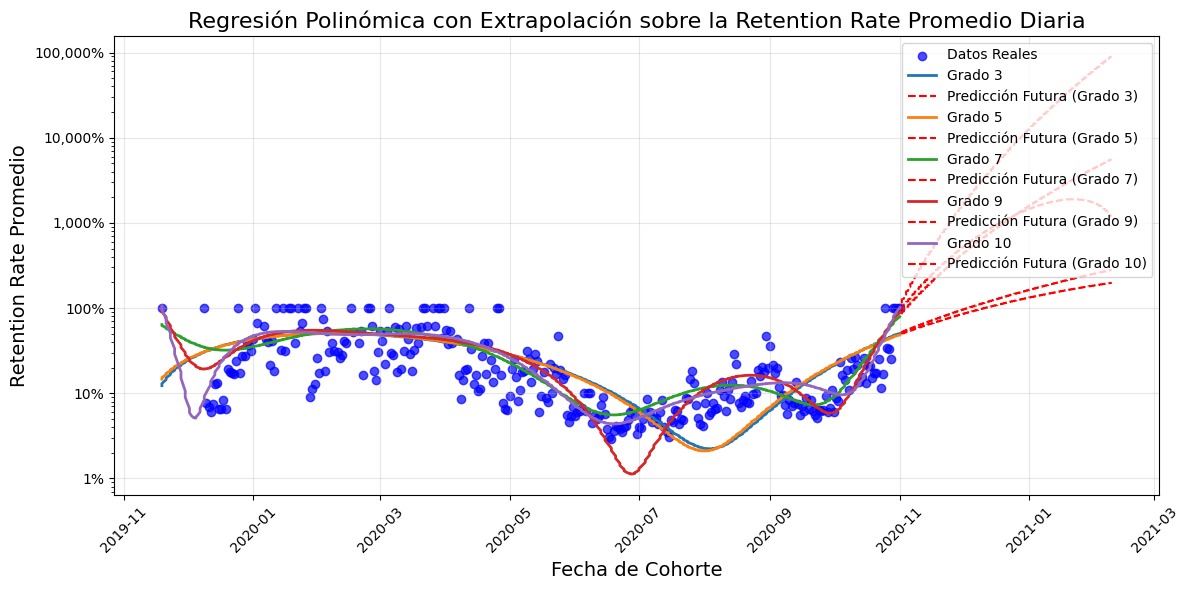

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Convertir cohort_d a datetime 
df_retention["cohort_d"] = pd.to_datetime(df_retention["cohort_d"])

# Agrupar por cohorte diaria y calcular la media de la Retention Rate
df_daily_mean = df_retention.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
    Mean_Retention_Rate=("Retention_Rate", "mean")
).reset_index()

# **Eliminar valores NaN en la Retention Rate**
df_daily_mean = df_daily_mean.dropna(subset=["Mean_Retention_Rate"])

# Convertir la fecha a un número ordinal
df_daily_mean["Date_Num"] = df_daily_mean["cohort_d"].map(pd.Timestamp.toordinal)

# Determinar el origen dinámico basado en el primer día de los datos
origin_date = df_daily_mean["cohort_d"].min()
results = []

# **Generar un rango continuo de fechas para la predicción**
date_range = np.linspace(df_daily_mean['Date_Num'].min(), df_daily_mean['Date_Num'].max(), 500).reshape(-1, 1)

# **Extender fechas para predicciones futuras**
additional_days = 100 # Ajusta la cantidad de días a extrapolar
future_dates = np.linspace(df_daily_mean['Date_Num'].max() + 1, df_daily_mean['Date_Num'].max() + additional_days, 500).reshape(-1, 1)

# **Crear el gráfico de dispersión**
plt.figure(figsize=(12, 6))
plt.scatter(df_daily_mean["cohort_d"], df_daily_mean["Mean_Retention_Rate"], alpha=0.7, label="Datos Reales", color="blue")

# **Probar diferentes grados de polinomio**
for degree in [3, 5, 7, 9, 10]:
 
    X = df_daily_mean[['Date_Num']].values
    y = df_daily_mean['Mean_Retention_Rate'].values

    # Escalar los valores de X
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Transformar las fechas en base al modelo polinómico
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_scaled)

    # Entrenar el modelo de regresión polinómica
    model = LinearRegression()
    model.fit(X_poly, y)

    # Predicción en el rango de fechas actuales
    date_range_scaled = scaler.transform(date_range)
    date_range_poly = poly.transform(date_range_scaled)
    predicted_rates = model.predict(date_range_poly)

    # Predicción en el rango futuro (extrapolación)
    future_dates_scaled = scaler.transform(future_dates)
    future_dates_poly = poly.transform(future_dates_scaled)
    future_predictions = model.predict(future_dates_poly)

    # Calcular métricas del modelo
    rmse = np.sqrt(mean_squared_error(y, model.predict(X_poly)))
    r2 = r2_score(y, model.predict(X_poly))
    results.append((degree, rmse, r2))

    print(f"Grado {degree} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # **Reconstrucción de las fechas originales**
    date_range_datetime = [origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in date_range.flatten()]
    future_dates_datetime = [origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in future_dates.flatten()]

    # **Graficar la curva de predicción (histórica)**
    plt.plot(date_range_datetime, predicted_rates, label=f'Grado {degree}', linewidth=2)

    # **Graficar la extrapolación futura en rojo con líneas discontinuas**
    plt.plot(future_dates_datetime, future_predictions, linestyle='dashed', color="red", label=f'Predicción Futura (Grado {degree})')

# **Encontrar el grado con el mejor RMSE y R2**
optimal_rmse = min(results, key=lambda x: x[1])
optimal_r2 = max(results, key=lambda x: x[2])

print("\nResultados:")
print(f"Mejor RMSE en grado {optimal_rmse[0]}: {optimal_rmse[1]:.4f}")
print(f"Mejor R2 en grado {optimal_r2[0]}: {optimal_r2[2]:.4f}")

# Configurar el gráfico con escala logarítmica
plt.title('Regresión Polinómica con Extrapolación sobre la Retention Rate Promedio Diaria', fontsize=16)
plt.xlabel('Fecha de Cohorte', fontsize=14)
plt.ylabel('Retention Rate Promedio', fontsize=14)
plt.yscale('log') #escala logaritmica
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Grado 3 - RMSE: 0.2274, R²: 0.3449
Grado 5 - RMSE: 0.2281, R²: 0.3412
Grado 7 - RMSE: 0.2266, R²: 0.3497
Grado 8 - RMSE: 0.2171, R²: 0.4030
Grado 9 - RMSE: 0.2178, R²: 0.3991
Grado 10 - RMSE: 0.2113, R²: 0.4346

Resultados:
Mejor RMSE en grado 10: 0.2113
Mejor R2 en grado 10: 0.4346


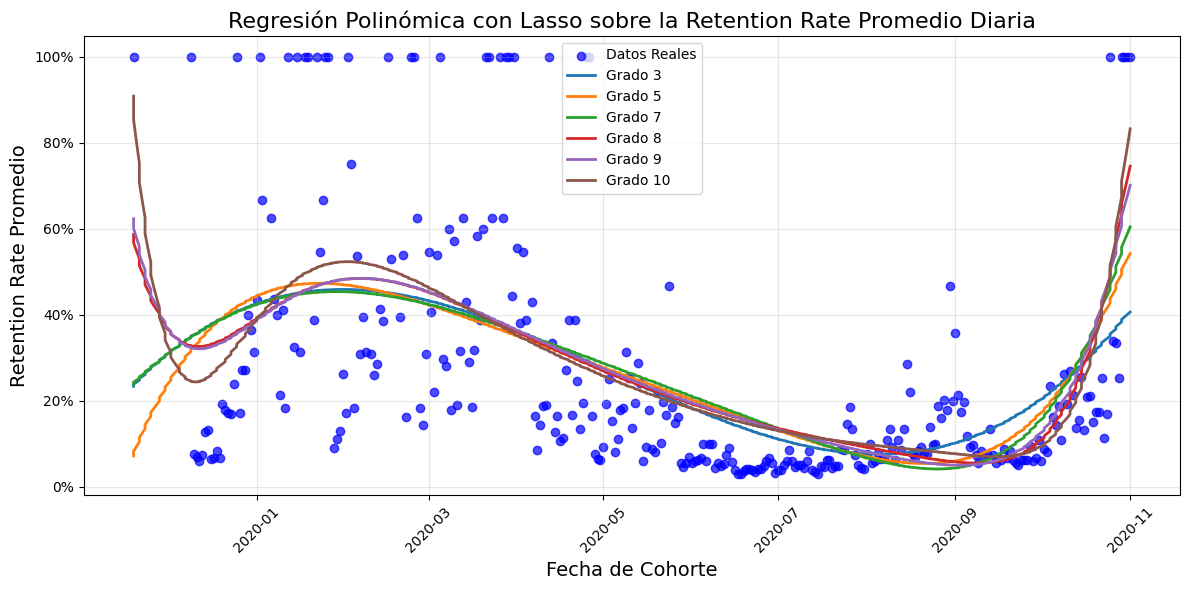

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Convertir cohort_d a datetime para agrupar por días
df_retention["cohort_d"] = pd.to_datetime(df_retention["cohort_d"])

# Agrupar por cohorte diaria y calcular la media de la Retention Rate
df_daily_mean = df_retention.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
    Mean_Retention_Rate=("Retention_Rate", "mean")
).reset_index()

# **Eliminar valores NaN en la Retention Rate**
df_daily_mean = df_daily_mean.dropna(subset=["Mean_Retention_Rate"])

# Convertir la fecha a un número ordinal
df_daily_mean["Date_Num"] = df_daily_mean["cohort_d"].map(pd.Timestamp.toordinal)

# Determinar el origen dinámico basado en el primer día de los datos
origin_date = df_daily_mean["cohort_d"].min()
results = []

#  Aplicar Regresión Polinómica con Lasso
plt.figure(figsize=(12, 6))

# x = Fechas ordinales, y = Retention Rate Media
X = df_daily_mean[['Date_Num']].values
y = df_daily_mean['Mean_Retention_Rate'].values

# Escalar las fechas ordinales
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Generar un rango continuo de fechas para la predicción
date_range = np.linspace(df_daily_mean['Date_Num'].min(), df_daily_mean['Date_Num'].max(), 500).reshape(-1, 1)
date_range_scaled = scaler.transform(date_range)

# Crear el gráfico de dispersión
plt.scatter(df_daily_mean["cohort_d"], df_daily_mean["Mean_Retention_Rate"], alpha=0.7, label="Datos Reales", color="blue")

# Probar diferentes grados de polinomio con Lasso Regression
alpha = 0.01  # Regularización para Lasso (puedes ajustar este valor según el dataset)
for degree in [3, 5, 7, 8, 9, 10]:
    # Crear el modelo polinómico con el grado actual
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_scaled)

    # Entrenar el modelo de regresión polinómica con Lasso
    model = Lasso(alpha=alpha, max_iter=10000)  # max_iter aumentado para asegurar convergencia
    model.fit(X_poly, y)

    predictions = model.predict(X_poly)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    results.append((degree, rmse, r2))

    print(f"Grado {degree} - RMSE: {rmse:.4f}, R²: {r2:.4f}")     

    # Transformar el rango continuo de fechas
    date_range_poly = poly.transform(date_range_scaled)
    predicted_rates = model.predict(date_range_poly)

    # Reconstruir las fechas usando el rango de fechas original
    date_range_datetime = [origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in date_range.flatten()]

    # Graficar la curva de predicción
    plt.plot(date_range_datetime, predicted_rates, label=f'Grado {degree}', linewidth=2)

# Encontrar el grado con el mejor RMSE y R2
optimal_rmse = min(results, key=lambda x: x[1])
optimal_r2 = max(results, key=lambda x: x[2])

print("\nResultados:")
print(f"Mejor RMSE en grado {optimal_rmse[0]}: {optimal_rmse[1]:.4f}")
print(f"Mejor R2 en grado {optimal_r2[0]}: {optimal_r2[2]:.4f}")


plt.title('Regresión Polinómica con Lasso sobre la Retention Rate Promedio Diaria', fontsize=16)
plt.xlabel('Fecha de Cohorte', fontsize=14)
plt.ylabel('Retention Rate Promedio', fontsize=14)
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Grado 3 - RMSE: 0.2783, R²: 0.0191
Grado 5 - RMSE: 0.2759, R²: 0.0361
Grado 7 - RMSE: 0.2756, R²: 0.0380

Resultados:
Mejor RMSE en grado 7: 0.2756
Mejor R2 en grado 7: 0.0380


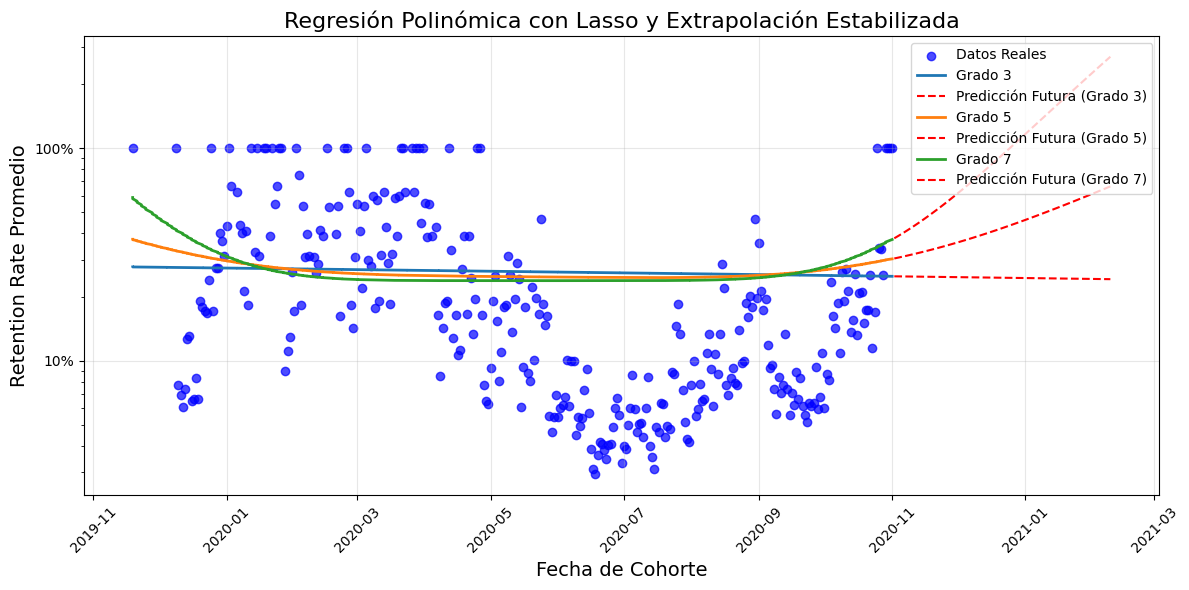

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Convertir cohort_d a datetime para agrupar por días
df_retention["cohort_d"] = pd.to_datetime(df_retention["cohort_d"])

# Agrupar por cohorte diaria y calcular la media de la Retention Rate
df_daily_mean = df_retention.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
    Mean_Retention_Rate=("Retention_Rate", "mean")
).reset_index()

# **Eliminar valores NaN en la Retention Rate**
df_daily_mean = df_daily_mean.dropna(subset=["Mean_Retention_Rate"])

# Convertir la fecha a un número ordinal
df_daily_mean["Date_Num"] = df_daily_mean["cohort_d"].map(pd.Timestamp.toordinal)

# Determinar el origen dinámico basado en el primer día de los datos
origin_date = df_daily_mean["cohort_d"].min()
results = []

# Aplicar Regresión Polinómica con Lasso
plt.figure(figsize=(12, 6))

# x = Fechas ordinales, y = Retention Rate Media
X = df_daily_mean[['Date_Num']].values
y = df_daily_mean['Mean_Retention_Rate'].values

# Escalar las fechas ordinales
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **Generar un rango continuo de fechas para la predicción**
date_range = np.linspace(df_daily_mean['Date_Num'].min(), df_daily_mean['Date_Num'].max(), 500).reshape(-1, 1)
date_range_scaled = scaler.transform(date_range)

# **Extender fechas para predicciones futuras con escalado correcto**
additional_days = 100  # Evitar oscilaciones extremas
future_dates = np.linspace(df_daily_mean['Date_Num'].max() + 1, df_daily_mean['Date_Num'].max() + additional_days, 100).reshape(-1, 1)
future_dates_scaled = scaler.transform(future_dates)

# **Crear el gráfico de dispersión**
plt.scatter(df_daily_mean["cohort_d"], df_daily_mean["Mean_Retention_Rate"], alpha=0.7, label="Datos Reales", color="blue")

# **Probar diferentes grados de polinomio con Lasso Regression**
alpha = 0.1  # Mayor regularización para evitar explosiones
for degree in [3, 5, 7]:  # Reducir grados para estabilidad
    # Crear el modelo polinómico con el grado actual
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_scaled)

    # Entrenar el modelo de regresión polinómica con Lasso
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_poly, y)

    predictions = model.predict(X_poly)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    results.append((degree, rmse, r2))

    print(f"Grado {degree} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # Predicción en el rango de fechas actuales
    date_range_poly = poly.transform(date_range_scaled)
    predicted_rates = model.predict(date_range_poly)

    # Predicción en el rango futuro (extrapolación)
    future_dates_poly = poly.transform(future_dates_scaled)
    future_predictions = model.predict(future_dates_poly)

    # Reconstrucción de las fechas originales
    date_range_datetime = [origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in date_range.flatten()]
    future_dates_datetime = [origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in future_dates.flatten()]

    # Graficar la curva de predicción (histórica)
    plt.plot(date_range_datetime, predicted_rates, label=f'Grado {degree}', linewidth=2)

    # Graficar la extrapolación futura en rojo con líneas discontinuas
    plt.plot(future_dates_datetime, future_predictions, linestyle='dashed', color="red", label=f'Predicción Futura (Grado {degree})')

# **Encontrar el grado con el mejor RMSE y R2**
optimal_rmse = min(results, key=lambda x: x[1])
optimal_r2 = max(results, key=lambda x: x[2])

print("\nResultados:")
print(f"Mejor RMSE en grado {optimal_rmse[0]}: {optimal_rmse[1]:.4f}")
print(f"Mejor R2 en grado {optimal_r2[0]}: {optimal_r2[2]:.4f}")

# **Configurar el gráfico**
plt.title('Regresión Polinómica con Lasso y Extrapolación Estabilizada', fontsize=16)
plt.xlabel('Fecha de Cohorte', fontsize=14)
plt.ylabel('Retention Rate Promedio', fontsize=14)
plt.grid(alpha=0.3)
plt.yscale('log')  # 👈 Habilita la escala logarítmica en el eje Y
plt.xticks(rotation=45)
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


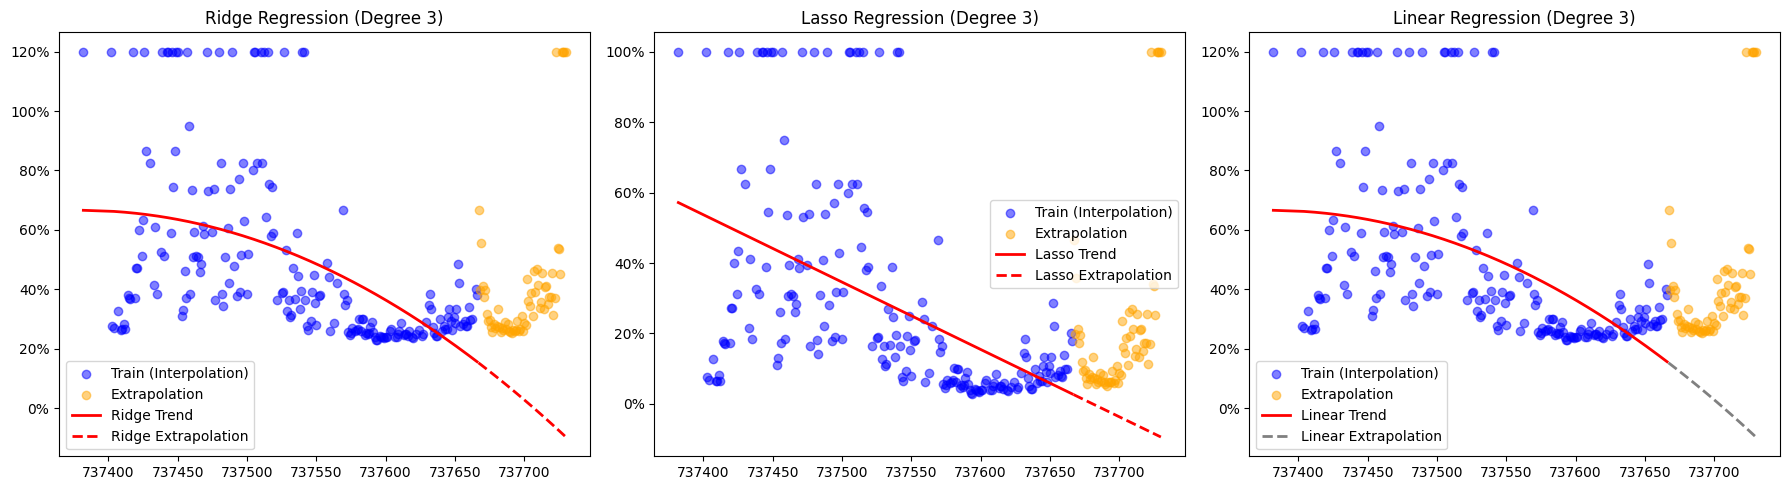

Degree 3: Ridge MSE=0.0659, R² Extrapolation=-2.8339
Degree 3: Lasso MSE=0.0654, R² Extrapolation=-1.1877
Degree 3: Linear MSE=0.2295, R² Extrapolation=-2.8339


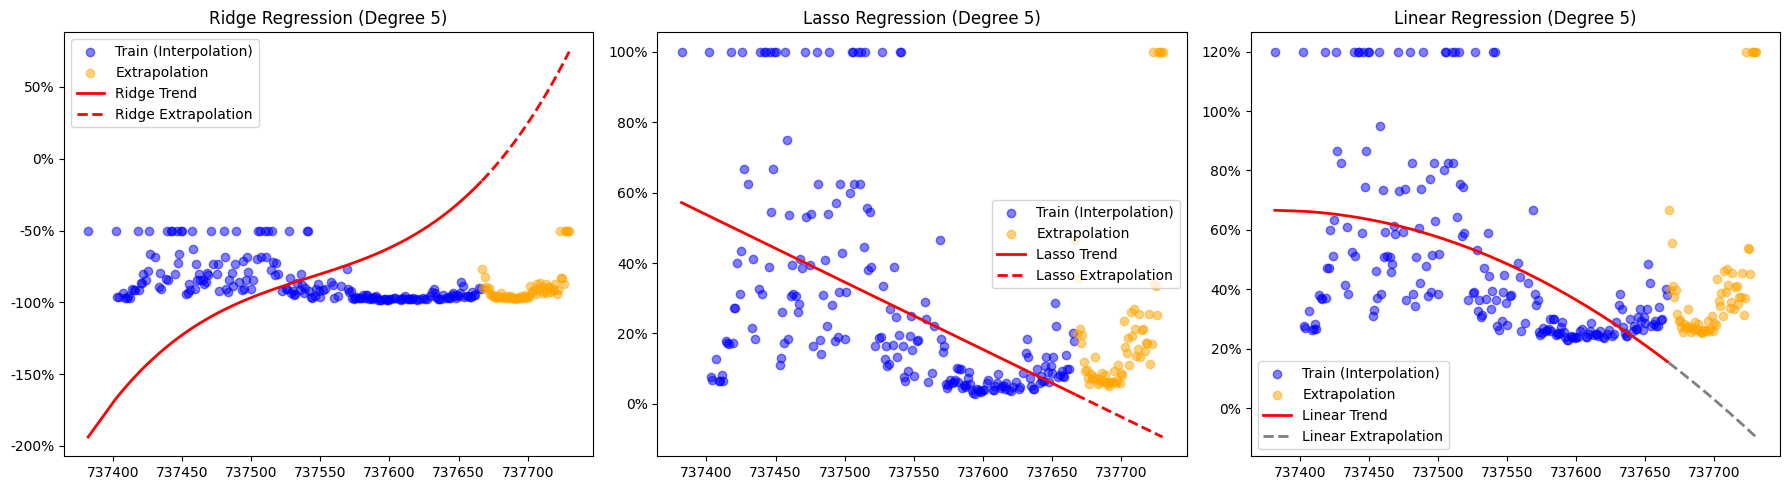

Degree 5: Ridge MSE=0.1027, R² Extrapolation=-89.6924
Degree 5: Lasso MSE=0.0654, R² Extrapolation=-1.1880
Degree 5: Linear MSE=0.2295, R² Extrapolation=-2.8337


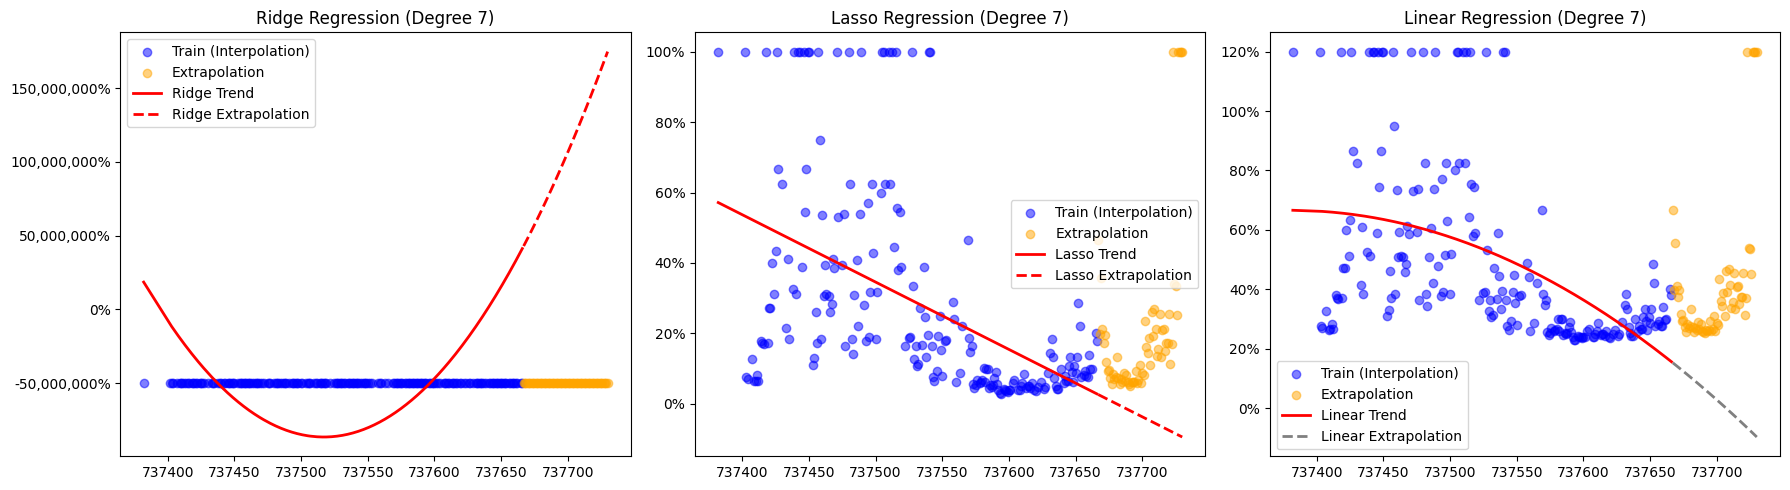

Degree 7: Ridge MSE=7705389604172.1631, R² Extrapolation=-170748605458628.5625
Degree 7: Lasso MSE=0.0654, R² Extrapolation=-1.1883
Degree 7: Linear MSE=0.2295, R² Extrapolation=-2.8336


Degree 8: Ridge MSE=24187455562018660352.0000, R² Extrapolation=-78448432303228452864.0000
Degree 8: Lasso MSE=0.0654, R² Extrapolation=-1.1885
Degree 8: Linear MSE=0.2294, R² Extrapolation=-2.8335


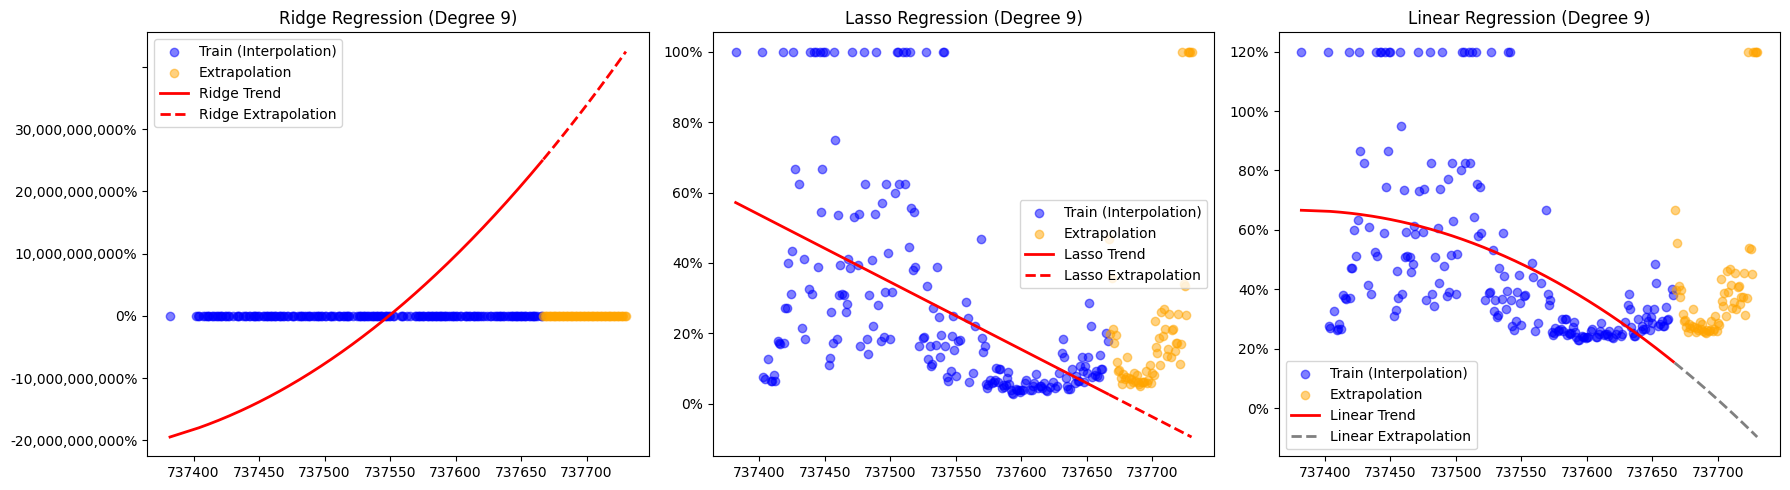

Degree 9: Ridge MSE=11241312252063253528576.0000, R² Extrapolation=-1929944977161495808.0000
Degree 9: Lasso MSE=0.0654, R² Extrapolation=-1.1887
Degree 9: Linear MSE=0.2294, R² Extrapolation=-2.8334


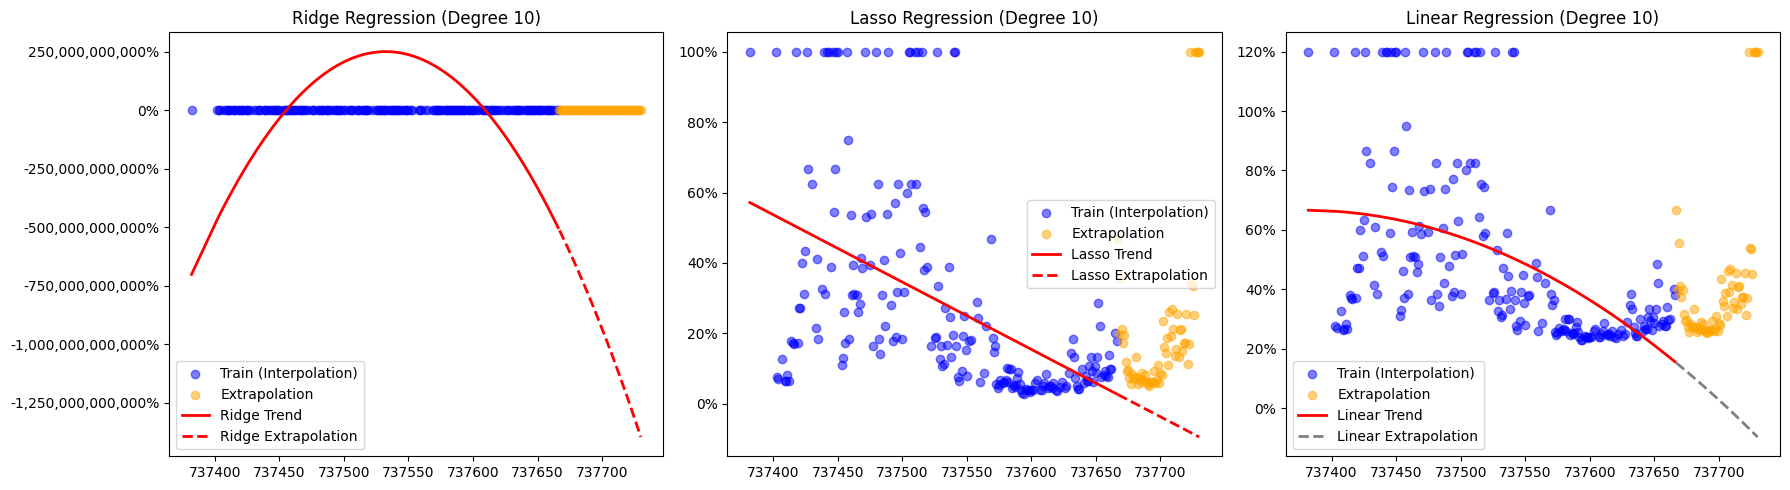

Degree 10: Ridge MSE=148252202192737075200.0000, R² Extrapolation=-6185089111988132380672.0000
Degree 10: Lasso MSE=0.0654, R² Extrapolation=-1.1890
Degree 10: Linear MSE=0.2294, R² Extrapolation=-2.8334


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

warnings.filterwarnings('ignore')

# Convertir cohort_d a datetime para agrupar por días
df_retention["cohort_d"] = pd.to_datetime(df_retention["cohort_d"])

# Agrupar por cohorte diaria y calcular la media de la Retention Rate
df_daily_mean = df_retention.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
    Mean_Retention_Rate=("Retention_Rate", "mean")
).reset_index()

# **Eliminar valores NaN en la Retention Rate**
df_daily_mean = df_daily_mean.dropna(subset=["Mean_Retention_Rate"])

# Convertir la fecha a un número ordinal
df_daily_mean["Date_Num"] = df_daily_mean["cohort_d"].map(pd.Timestamp.toordinal)

# **División de datos en interpolación (80%) y extrapolación (20%)**
X = df_daily_mean[['Date_Num']].values
y = df_daily_mean['Mean_Retention_Rate'].values

X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.2, shuffle=True)

# **Parámetros para la regresión**
poly_degrees = [3, 5, 7, 8, 9, 10]  # Diferentes grados de polinomio
alpha_values = [0.01, 0.1, 1, 10, 100]  # Valores de alpha para Ridge y Lasso
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Validación cruzada

# **Iterar sobre cada grado polinómico**
for degree in poly_degrees:
    best_ridge, best_lasso, best_linear = None, None, None
    best_ridge_mse, best_lasso_mse, best_linear_mse = float('inf'), float('inf'), float('inf')

    # **Optimización de alpha para Ridge y Lasso**
    for alpha in alpha_values:
        # Ridge Regression
        ridge_model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
        ridge_preds = cross_val_predict(ridge_model, X_train, y_train, cv=kf)
        ridge_mse = mean_squared_error(y_train, ridge_preds)

        if ridge_mse < best_ridge_mse:
            best_ridge_mse = ridge_mse
            best_ridge = Ridge(alpha=alpha)

        # Lasso Regression
        lasso_model = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha, max_iter=10000))
        lasso_preds = cross_val_predict(lasso_model, X_train, y_train, cv=kf)
        lasso_mse = mean_squared_error(y_train, lasso_preds)

        if lasso_mse < best_lasso_mse:
            best_lasso_mse = lasso_mse
            best_lasso = Lasso(alpha=alpha, max_iter=10000)

    # **Entrenamiento de los mejores modelos**
    ridge_pipeline = make_pipeline(PolynomialFeatures(degree), best_ridge)
    lasso_pipeline = make_pipeline(PolynomialFeatures(degree), best_lasso)
    linear_pipeline = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    ridge_pipeline.fit(X_interp, y_interp)
    lasso_pipeline.fit(X_interp, y_interp)
    linear_pipeline.fit(X_interp, y_interp)

    # **Predicciones**
    ridge_y_pred_interp = ridge_pipeline.predict(X_interp)
    ridge_y_pred_extra = ridge_pipeline.predict(X_extrap)

    lasso_y_pred_interp = lasso_pipeline.predict(X_interp)
    lasso_y_pred_extra = lasso_pipeline.predict(X_extrap)

    linear_y_pred_interp = linear_pipeline.predict(X_interp)
    linear_y_pred_extra = linear_pipeline.predict(X_extrap)

    # **Evaluación en extrapolación**
    ridge_r2_extra = r2_score(y_extrap, ridge_y_pred_extra)
    lasso_r2_extra = r2_score(y_extrap, lasso_y_pred_extra)
    linear_r2_extra = r2_score(y_extrap, linear_y_pred_extra)

    # **Gráficos**
    plt.figure(figsize=(18, 5))

    # Ridge Regression
    plt.subplot(1, 3, 1)
    plt.scatter(X_train, y_train, color='blue', alpha=0.5, label="Train (Interpolation)")
    plt.scatter(X_extrap, y_extrap, color='orange', alpha=0.5, label="Extrapolation")
    plt.plot(X_interp, ridge_y_pred_interp, color='red', label="Ridge Trend", linewidth=2)
    plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
    plt.plot(X_extrap, ridge_y_pred_extra, color='red', linestyle="dashed", label="Ridge Extrapolation", linewidth=2)
    plt.title(f'Ridge Regression (Degree {degree})')
    plt.legend()

    # Lasso Regression
    plt.subplot(1, 3, 2)
    plt.scatter(X_train, y_train, color='blue', alpha=0.5, label="Train (Interpolation)")
    plt.scatter(X_extrap, y_extrap, color='orange', alpha=0.5, label="Extrapolation")
    plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
    plt.plot(X_interp, lasso_y_pred_interp, color='red', label="Lasso Trend", linewidth=2)
    plt.plot(X_extrap, lasso_y_pred_extra, color='red', linestyle="dashed", label="Lasso Extrapolation", linewidth=2)
    plt.title(f'Lasso Regression (Degree {degree})')
    plt.legend()

    # Linear Regression
    plt.subplot(1, 3, 3)
    plt.scatter(X_train, y_train, color='blue', alpha=0.5, label="Train (Interpolation)")
    plt.scatter(X_extrap, y_extrap, color='orange', alpha=0.5, label="Extrapolation")
    plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
    plt.plot(X_interp, linear_y_pred_interp, color='red', label="Linear Trend", linewidth=2)
    plt.plot(X_extrap, linear_y_pred_extra, color='gray', linestyle="dashed", label="Linear Extrapolation", linewidth=2)
    plt.title(f'Linear Regression (Degree {degree})')
    plt.legend()
 

    plt.tight_layout()
    plt.show()

    print(f"Degree {degree}: Ridge MSE={best_ridge_mse:.4f}, R² Extrapolation={ridge_r2_extra:.4f}")
    print(f"Degree {degree}: Lasso MSE={best_lasso_mse:.4f}, R² Extrapolation={lasso_r2_extra:.4f}")
    print(f"Degree {degree}: Linear MSE={mean_squared_error(y_extrap, linear_y_pred_extra):.4f}, R² Extrapolation={linear_r2_extra:.4f}")


TASA DE ABANDONO


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Cargar datos
fees = pd.read_csv('./data/extract - fees - data analyst - .csv')
cash_request = pd.read_csv('./data/extract - cash request - data analyst.csv')

# Copia de seguridad
cr = cash_request.copy()
cr = cr[['amount', 'created_at', 'user_id', 'deleted_account_id', 'transfer_type']]

# Convertir 'created_at' a datetime y eliminar zona horaria si existe
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr['created_at'] = cr['created_at'].dt.tz_localize(None)

# Rellenar 'user_id' con 'deleted_account_id' donde sea NaN
cr['user_id'] = cr['user_id'].combine_first(cr['deleted_account_id'])
cr.drop(columns=['deleted_account_id'], inplace=True)

# Convertir a periodos diarios en lugar de mensuales
cr['Day'] = cr['created_at'].dt.to_period('D')  # Se usa 'D' para periodos diarios

# Calcular la cohorte diaria (primer día de uso por usuario)
cr['cohort_d'] = cr.groupby('user_id')['Day'].transform('min')

# Agrupar por cohort_d y contar usuarios iniciales
cohort_daily_initial_sizes = cr.groupby('cohort_d').agg(
    Number_of_initial_customers=('user_id', 'nunique')
).reset_index()

# Agrupar por cohort_d y Day para contar usuarios activos
cohort_daily_sizes = cr.groupby(['cohort_d', 'Day']).agg(
    Number_of_customers=('user_id', 'nunique')
).reset_index()

# Agrupar por cohort_d y Day para contar solicitudes
cohort_cash_daily = cr.groupby(['cohort_d', 'Day']).agg(
    Num_requests=('user_id', 'count')
).reset_index()

# Convertir 'Day' a datetime para cálculos correctos
cohort_daily_sizes['Day'] = cohort_daily_sizes['Day'].astype(str)
cohort_daily_sizes['Day'] = pd.to_datetime(cohort_daily_sizes['Day'])

# Calcular tasa de retención diaria
customers_daily_retention = cohort_daily_sizes.pivot(index='cohort_d', columns='Day', values='Number_of_customers')

# Dividir cada día por el número inicial de clientes en cada cohorte
customers_daily_retention = customers_daily_retention.div(
    cohort_daily_initial_sizes.set_index('cohort_d')['Number_of_initial_customers'], axis=0
)

# **📌 Calcular Tasa de Abandono (Churn Rate)**
customers_daily_churn = 1 - customers_daily_retention

# Convertir la tabla a formato largo para análisis de series temporales
df_churn = customers_daily_churn.reset_index().melt(id_vars=['cohort_d'], var_name='Day', value_name='Churn_Rate')

# Asegurar que 'Day' es datetime
df_churn['Day'] = pd.to_datetime(df_churn['Day'])

# Calcular la diferencia en días correctamente (desde cohort_d hasta Day)
df_churn['cohort_d'] = df_churn['cohort_d'].astype(str)  # Convertir a string para evitar errores
df_churn['cohort_d'] = pd.to_datetime(df_churn['cohort_d'])  # Convertir a datetime
df_churn['Day_Num'] = (df_churn['Day'] - df_churn['cohort_d']).dt.days

# Verificar los datos corregidos
df_churn


cohort_d        Day  Churn_Rate  Day_Num
0      2019-11-19 2019-11-19         0.0        0
1      2019-12-09 2019-11-19         NaN      -20
2      2019-12-10 2019-11-19         NaN      -21
3      2019-12-11 2019-11-19         NaN      -22
4      2019-12-12 2019-11-19         NaN      -23
...           ...        ...         ...      ...
104275 2020-10-28 2020-11-01         NaN        4
104276 2020-10-29 2020-11-01         NaN        3
104277 2020-10-30 2020-11-01         NaN        2
104278 2020-10-31 2020-11-01         NaN        1
104279 2020-11-01 2020-11-01         0.0        0

[104280 rows x 4 columns]

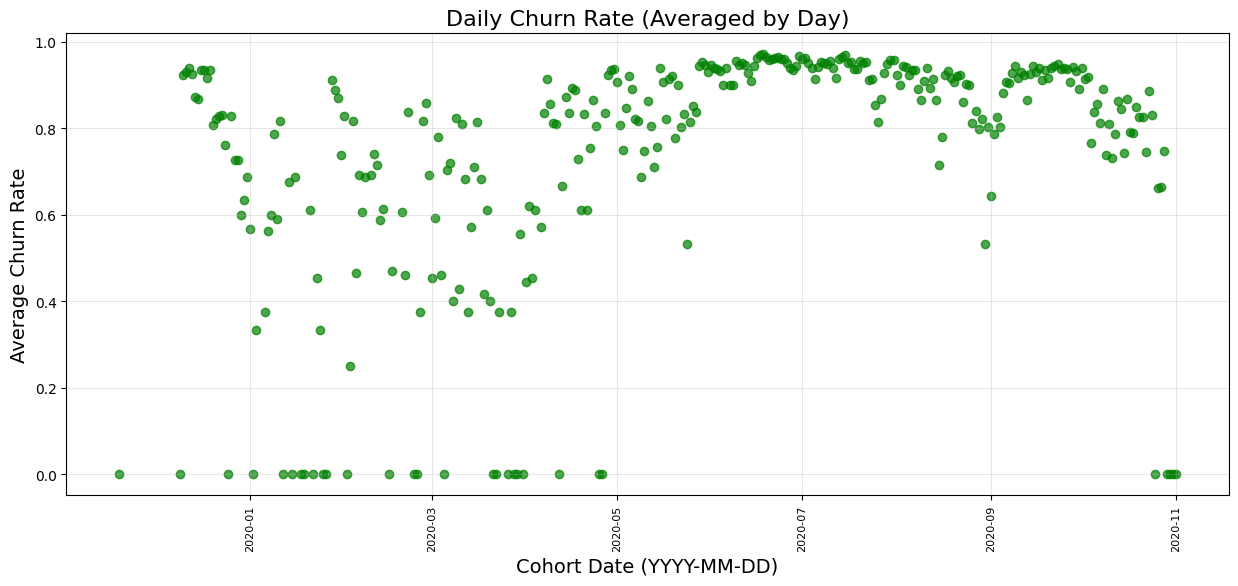

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Convertir cohort_d a datetime para agrupar por frecuencia de tiempo
df_churn["cohort_d"] = pd.to_datetime(df_churn["cohort_d"])

# Agrupar por día de cohorte y calcular la media de la Churn Rate
df_daily_churn_mean = df_churn.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
    Mean_Churn_Rate=("Churn_Rate", "mean")
).reset_index()

#  Gráfico de Dispersión con la Media Diaria de la Churn Rate
plt.figure(figsize=(15, 6))


plt.scatter(df_daily_churn_mean["cohort_d"], df_daily_churn_mean["Mean_Churn_Rate"], alpha=0.7, color="green")

plt.title("Daily Churn Rate (Averaged by Day)", fontsize=16)
plt.xlabel("Cohort Date (YYYY-MM-DD)", fontsize=14)  
plt.ylabel("Average Churn Rate", fontsize=14)  
plt.xticks(rotation=90, fontsize=8)  
plt.grid(alpha=0.3)
plt.show()


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Especificar el mes a analizar (AÑO-MES)
mes_especifico = "2020-02"  

# Convertir cohort_d a formato datetime si aún no lo está
df_daily_churn_mean["cohort_d"] = pd.to_datetime(df_daily_churn_mean["cohort_d"])

# Filtrar solo el mes específico
df_mes = df_daily_churn_mean[df_daily_churn_mean["cohort_d"].dt.strftime("%Y-%m") == mes_especifico].copy()

# Extraer el día del mes
df_mes["Día"] = df_mes["cohort_d"].dt.day

# Crear una tabla pivote con la media de Churn Rate diaria
churn_pivot = df_mes.pivot(index="Día", values="Mean_Churn_Rate", columns="cohort_d")

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Heatmap de Churn Rate
sns.heatmap(
    churn_pivot, 
    cmap="YlOrRd",  # Escala de colores para resaltar la tasa de abandono
    annot=True, 
    fmt=".2%",  # Convertir a porcentaje
    linewidths=0.5, 
    cbar_kws={'label': 'Churn Rate Media'}
)

# Títulos y etiquetas
plt.title(f"Heatmap de la Media Diaria de Churn Rate en {mes_especifico}", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Día del Mes", fontsize=14)
plt.xticks(rotation=45)  
plt.yticks(rotation=0)  
plt.show()


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')

# Convertir cohort_d a datetime
df_retention["cohort_d"] = pd.to_datetime(df_retention["cohort_d"])

# Calcular la Churn Rate (1 - Retention Rate)
df_retention["Churn_Rate"] = 1 - df_retention["Retention_Rate"]

# Agrupar por cohorte diaria y calcular la media de la Churn Rate
df_daily_churn = df_retention.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
    Mean_Churn_Rate=("Churn_Rate", "mean")
).reset_index()

# **Eliminar valores NaN en la Churn Rate**
df_daily_churn = df_daily_churn.dropna(subset=["Mean_Churn_Rate"])

# Convertir la fecha a un número ordinal
df_daily_churn["Date_Num"] = df_daily_churn["cohort_d"].map(pd.Timestamp.toordinal)

# Frecuencia temporal por días
freq = 'D'
label = 'Días'

# Aplicar Regresión Logarítmica a la Media Diaria de Churn Rate
X = np.log(df_daily_churn[['Date_Num']].values)  
y = df_daily_churn['Mean_Churn_Rate'].values

# Entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Generar predicciones
df_daily_churn['Predicted'] = model.predict(X)

# Calcular métricas de la regresión
rmse = np.sqrt(mean_squared_error(y, df_daily_churn['Predicted']))
r2 = r2_score(y, df_daily_churn['Predicted'])

print(f"Análisis de Regresión - RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Crear el gráfico de dispersión con la regresión
plt.figure(figsize=(12, 6))

# Gráfico de dispersión con la media diaria de churn rate
plt.scatter(df_daily_churn["cohort_d"], df_daily_churn["Mean_Churn_Rate"], alpha=0.7, label="Datos Reales", color="green")

# Curva de regresión logarítmica
plt.plot(df_daily_churn["cohort_d"], df_daily_churn["Predicted"], color="red", label="Regresión Lineal Log", linewidth=2)

plt.title(f'Churn Rate Promedio Diario con Regresión Logarítmica ({label})', fontsize=16)
plt.xlabel("Cohort Date (YYYY-MM-DD)", fontsize=14)
plt.ylabel("Average Churn Rate", fontsize=14)
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
plt.xticks(rotation=45, fontsize=10)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Análisis de Regresión - RMSE: 0.2597, R²: 0.1458


Grado 3 - RMSE: 0.2240, R²: 0.3644
Grado 5 - RMSE: 0.2240, R²: 0.3647
Grado 7 - RMSE: 0.2100, R²: 0.4415
Grado 8 - RMSE: 0.2044, R²: 0.4708
Grado 9 - RMSE: 0.2032, R²: 0.4768
Grado 10 - RMSE: 0.2002, R²: 0.4925

Resultados:
Mejor RMSE en grado 10: 0.2002
Mejor R2 en grado 10: 0.4925


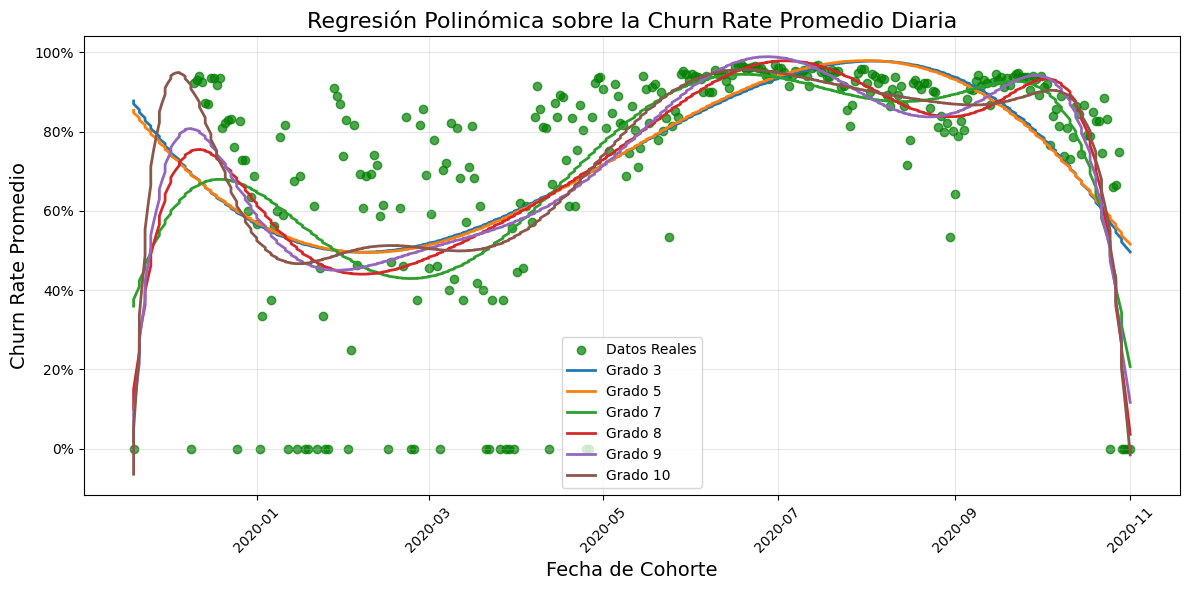

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Convertir cohort_d a datetime
df_retention["cohort_d"] = pd.to_datetime(df_retention["cohort_d"])

# Agrupar por cohorte diaria y calcular la media de la Retention Rate
df_daily_mean = df_retention.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
    Mean_Retention_Rate=("Retention_Rate", "mean")
).reset_index()

# **Eliminar valores NaN en la Retention Rate**
df_daily_mean = df_daily_mean.dropna(subset=["Mean_Retention_Rate"])

# Calcular la Churn Rate (Tasa de Abandono)
df_daily_mean["Churn_Rate"] = 1 - df_daily_mean["Mean_Retention_Rate"]

# Convertir la fecha a un número ordinal
df_daily_mean["Date_Num"] = df_daily_mean["cohort_d"].map(pd.Timestamp.toordinal)

# Determinar el origen dinámico basado en el primer día de los datos
origin_date = df_daily_mean["cohort_d"].min()
freq = 'D'
results = []

# Aplicar Regresión Polinómica de Diferentes Grados a la Churn Rate
plt.figure(figsize=(12, 6))

# x = Fechas ordinales, y = Churn Rate Media
X = df_daily_mean[['Date_Num']].values
y = df_daily_mean['Churn_Rate'].values

# Escalar las fechas ordinales
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Generar un rango continuo de fechas para la predicción
date_range = np.linspace(df_daily_mean['Date_Num'].min(), df_daily_mean['Date_Num'].max(), 500).reshape(-1, 1)
date_range_scaled = scaler.transform(date_range)

# Crear el gráfico de dispersión
plt.scatter(df_daily_mean["cohort_d"], df_daily_mean["Churn_Rate"], alpha=0.7, label="Datos Reales", color="green")

# Probar diferentes grados de polinomio
for degree in [3, 5, 7, 8, 9, 10]:
    # Crear el modelo polinómico con el grado actual
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_scaled)

    # Entrenar el modelo de regresión polinómica
    model = LinearRegression()
    model.fit(X_poly, y)

    predictions = model.predict(X_poly)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    results.append((degree, rmse, r2))

    print(f"Grado {degree} - RMSE: {rmse:.4f}, R²: {r2:.4f}")     

    # Transformar el rango continuo de fechas
    date_range_poly = poly.transform(date_range_scaled)
    predicted_churn = model.predict(date_range_poly)

    # Reconstruir las fechas usando el rango de fechas original
    date_range_datetime = [origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in date_range.flatten()]

    # Graficar la curva de predicción
    plt.plot(date_range_datetime, predicted_churn, label=f'Grado {degree}', linewidth=2)

# Encontrar el grado con el mejor RMSE y R2
optimal_rmse = min(results, key=lambda x: x[1])
optimal_r2 = max(results, key=lambda x: x[2])

print("\nResultados:")
print(f"Mejor RMSE en grado {optimal_rmse[0]}: {optimal_rmse[1]:.4f}")
print(f"Mejor R2 en grado {optimal_r2[0]}: {optimal_r2[2]:.4f}")

# Configurar el gráfico
plt.title('Regresión Polinómica sobre la Churn Rate Promedio Diaria', fontsize=16)
plt.xlabel('Fecha de Cohorte', fontsize=14)
plt.ylabel('Churn Rate Promedio', fontsize=14)
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Grado 3 - RMSE: 0.2240, R²: 0.3644
Grado 5 - RMSE: 0.2240, R²: 0.3647
Grado 7 - RMSE: 0.2100, R²: 0.4415
Grado 9 - RMSE: 0.2032, R²: 0.4768
Grado 10 - RMSE: 0.2002, R²: 0.4925

Resultados:
Mejor RMSE en grado 10: 0.2002
Mejor R2 en grado 10: 0.4925


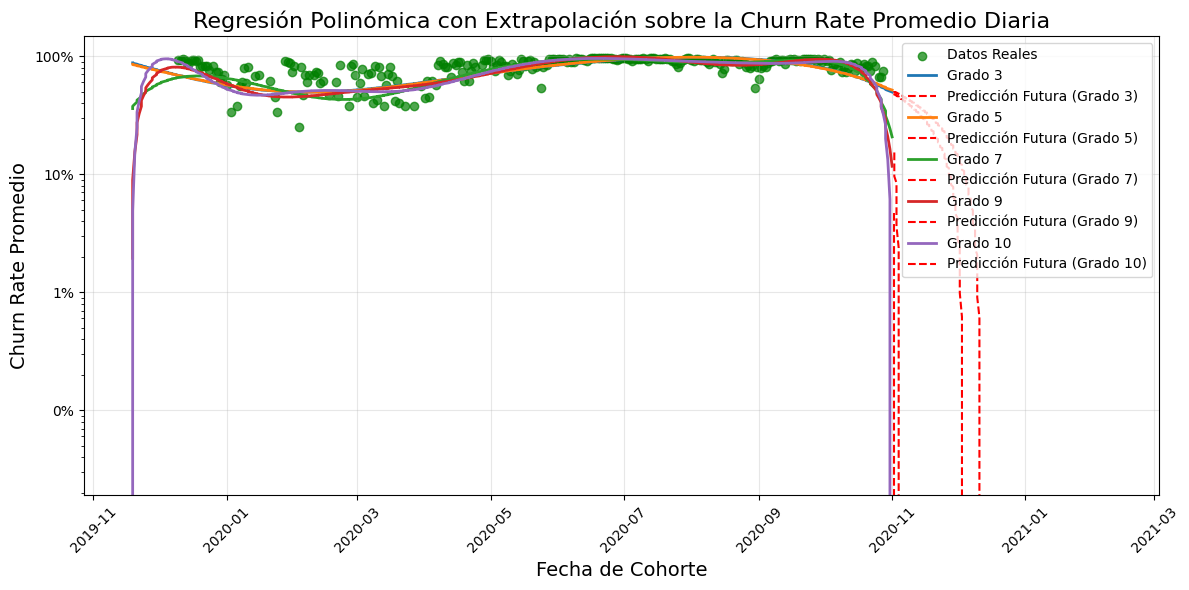

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Convertir cohort_d a datetime 
df_retention["cohort_d"] = pd.to_datetime(df_retention["cohort_d"])

# Agrupar por cohorte diaria y calcular la media de la Retention Rate
df_daily_mean = df_retention.groupby(pd.Grouper(key="cohort_d", freq="D")).agg(
    Mean_Retention_Rate=("Retention_Rate", "mean")
).reset_index()

# **Eliminar valores NaN en la Retention Rate**
df_daily_mean = df_daily_mean.dropna(subset=["Mean_Retention_Rate"])

# Calcular la Churn Rate (Tasa de Abandono)
df_daily_mean["Churn_Rate"] = 1 - df_daily_mean["Mean_Retention_Rate"]

# Convertir la fecha a un número ordinal
df_daily_mean["Date_Num"] = df_daily_mean["cohort_d"].map(pd.Timestamp.toordinal)

# Determinar el origen dinámico basado en el primer día de los datos
origin_date = df_daily_mean["cohort_d"].min()
results = []

# **Generar un rango continuo de fechas para la predicción**
date_range = np.linspace(df_daily_mean['Date_Num'].min(), df_daily_mean['Date_Num'].max(), 500).reshape(-1, 1)

# **Extender fechas para predicciones futuras**
additional_days = 100  # Ajusta la cantidad de días a extrapolar
future_dates = np.linspace(df_daily_mean['Date_Num'].max() + 1, df_daily_mean['Date_Num'].max() + additional_days, 500).reshape(-1, 1)

# **Crear el gráfico de dispersión**
plt.figure(figsize=(12, 6))
plt.scatter(df_daily_mean["cohort_d"], df_daily_mean["Churn_Rate"], alpha=0.7, label="Datos Reales", color="green")

# **Probar diferentes grados de polinomio**
for degree in [3, 5, 7, 9, 10]:
 
    X = df_daily_mean[['Date_Num']].values
    y = df_daily_mean['Churn_Rate'].values

    # Escalar los valores de X
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Transformar las fechas en base al modelo polinómico
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_scaled)

    # Entrenar el modelo de regresión polinómica
    model = LinearRegression()
    model.fit(X_poly, y)

    # Predicción en el rango de fechas actuales
    date_range_scaled = scaler.transform(date_range)
    date_range_poly = poly.transform(date_range_scaled)
    predicted_churn = model.predict(date_range_poly)

    # Predicción en el rango futuro (extrapolación)
    future_dates_scaled = scaler.transform(future_dates)
    future_dates_poly = poly.transform(future_dates_scaled)
    future_predictions = model.predict(future_dates_poly)

    # Calcular métricas del modelo
    rmse = np.sqrt(mean_squared_error(y, model.predict(X_poly)))
    r2 = r2_score(y, model.predict(X_poly))
    results.append((degree, rmse, r2))

    print(f"Grado {degree} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # **Reconstrucción de las fechas originales**
    date_range_datetime = [origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in date_range.flatten()]
    future_dates_datetime = [origin_date + pd.Timedelta(days=int(num - df_daily_mean['Date_Num'].min())) for num in future_dates.flatten()]

    # **Graficar la curva de predicción (histórica)**
    plt.plot(date_range_datetime, predicted_churn, label=f'Grado {degree}', linewidth=2)

    # **Graficar la extrapolación futura en rojo con líneas discontinuas**
    plt.plot(future_dates_datetime, future_predictions, linestyle='dashed', color="red", label=f'Predicción Futura (Grado {degree})')

# **Encontrar el grado con el mejor RMSE y R2**
optimal_rmse = min(results, key=lambda x: x[1])
optimal_r2 = max(results, key=lambda x: x[2])

print("\nResultados:")
print(f"Mejor RMSE en grado {optimal_rmse[0]}: {optimal_rmse[1]:.4f}")
print(f"Mejor R2 en grado {optimal_r2[0]}: {optimal_r2[2]:.4f}")

# Configurar el gráfico con escala logarítmica
plt.title('Regresión Polinómica con Extrapolación sobre la Churn Rate Promedio Diaria', fontsize=16)
plt.xlabel('Fecha de Cohorte', fontsize=14)
plt.ylabel('Churn Rate Promedio', fontsize=14)
plt.yscale('log')  # Escala logarítmica
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
